# Исследование данных медицинского центра за 2021-2022 г.г.
## Выполнил: Косарева Олеся Юрьевна (x_olesya_kosareva) / (Masterskaya_25DA+_1_Аналитика данных мед.центра)


**Цель проекта:**

Оценить вклад различных факторов в изменение средней стоимости лечения в медицинской клинике в разные годы.
Проанализировать изменение выручки медицинского центра в 2022 году относительно 2021 и выявить ключевые факторы, повлиявшие на это изменение.

**Ход исследования:**
* чтение, обзор и предобработка данных при необходимости
* проанализировать динамику выручки и количества пациентов по месяцам и годам
* вывести динамику стоимости визита, количества услуг за визит, стоимостей услуг
* для каждой категории (пол пациента, возраст пациента, ценовая категория услуг) выделить топ-10 популярных услуг и проанализировать динамику изменения стоимостей этих услуг
* проверить, есть ли зависимость выручки от изменения количества визитов за день, количества услуг за визит и стоимости визита
* проверить, влияет ли на выручку количество постоянных клиентов, либо количество "разовых" клиентов
* проверить, влияет ли на выручку изменение количества медицинских кейсов, их стоимости и длительности
* проверить, влияет ли на выручку пол, возраст пациента и категория услуг
* проверить гипотезы:
  * Проверим, выше ли средняя стоимость визита пациентов женского пола среднего чека пациентов мужского пола
  * Проверим, равна ли средняя стоимость визита пациентов категорий 25 <= возраст < 35 и 18 <= возраст < 25
  * Проверим, равна ли средняя стоимость визита пациентов категорий 35 <= возраст < 45 и 45 <= возраст < 55
* подготовить выводы

**Описание данных**

* record_id - уникальный идентификатор строки данных;
* service_date - дата оказания медицинской услуги;
* service_name - наименование медицинской услуги;
* service_number - количество услуг;
* service_amount - сумма выплат (стоимость оказанных услуг в рублях);
* insured - уникальный идентификатор пациента;
* sex_id - пол пациента;
* age_for_service_date - возраст пациента.

## Оглавление

[1. Загрузка библиотек и чтение данных](#start)

[2. Определение функций](#functions)

[3. Чтение данных](#read)

[4. Предобработка данных](#data_preparation)

   [4.1. Изменение формата даты и добавления столбцов 'year' и 'month'](#data_format)
   
   [4.2. Обработка пропусков в 'sex_id' и определение пола клиента](#sex_id)
   
   [4.3. Обработка явных и неявных дубликатов](#duplicates)
   
   [4.4. Определение категорий услуг](#service_category)
   
   [4.5. Определение возрастных категорий](#age_category)
   
   [4.6. Определение ценовых категорий](#amount_category)
   
[5. Исследовательский анализ данных](#data_analysis)

   [5.1. Динамика выручки](#total_amount)
   
   [5.2. Расчет визитов и средней стоимости услуг за визит](#visits)
   
   [5.3. Расчет обратившихся в месяц](#visits_month)
   
   [5.4. Оценка пациентов с точки зрения "разовых" и "постоянных" клиентов](#visit_1)
   
   [5.5. Динамика изменения стоимости самых популярных услуг по месяцам](#top_10)
   
   [5.6. Медицинский кейс](#med_case)
   
   [5.7. Оценка зависимости выручки от различных категорий](#total_amount_category)

[6. Общий вывод](#summary)

<a name='start'></a>
## 1. Загрузка библиотек и чтение данных

In [1]:
!pip install xlrd 
!pip install openpyxl

In [2]:
# загрузка библиотек
from io import BytesIO  
import requests

import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format

import numpy as np
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
# установка единого стиля
plt.style.use('seaborn')

from scipy import stats as st 
from scipy.stats import binom, norm
from math import factorial
from math import sqrt


<a name='functions'></a>
## 2. Определение функций

In [3]:
def plot_group(data, dimension):
    """
    функция группировки пользователей по одному признаку и формирования сводных таблиц;
    расчитывает сводные таблицы по заданному признаку "dimension": кол-во застрахованных и выручка по всем данным,
    строит соответственно 2 столбчатые диаграммы;
    возвращает одну таблицу по заданному признаку "dimension"
    """
   
    grouped_users = (
        data.groupby(['service_date', dimension], as_index=False).agg({'insured':'nunique', 'service_amount':'sum'}) 
    ) 
    grouped_users = grouped_users.groupby(dimension).agg({'insured':'sum', 'service_amount':'sum'}) 
    grouped_users['insured/ total, %'] = grouped_users['insured']/grouped_users['insured'].sum()*100
    grouped_users['service_amount/ total, %'] = grouped_users['service_amount']/grouped_users['service_amount'].sum()*100
    grouped_users = grouped_users.sort_values(by='service_amount/ total, %', ascending=False)

    plt.figure(figsize=(7, 4))
   
    ax1 = plt.subplot(2,1,1)
    grouped_users.plot(kind='barh', y='insured/ total, %', ax=ax1)
    plt.xlabel('Количество визитов, %')
    plt.ylabel('')
    ax1.get_legend().remove()
    plt.title(f'Диаграмма распределения кол-ва визитов по {dimension} \n')
    
    ax2 = plt.subplot(2,1,2)
    grouped_users.plot(kind='barh', y='service_amount/ total, %', ax=ax2)
    plt.xlabel('Суммарная выручка, %')
    plt.ylabel('')
    ax2.get_legend().remove()
    plt.title(f'Диаграмма распределения выручки по {dimension} \n')
    
    plt.tight_layout()
    plt.show()
    
    return grouped_users;

In [4]:
def age_category(age):
    """
    функция категоризации по возрасту
    """
    try:
        if 0 <= age < 18:
            return '0 <= возраст < 18'
        elif 18 <= age < 25:
            return '18 <= возраст < 25'
        elif 25 <= age < 35:
            return '25 <= возраст < 35'
        elif 35 <= age < 45:
            return '35 <= возраст < 45'
        elif 45 <= age < 55:
            return '45 <= возраст < 55'
        elif 55 <= age < 65:
            return '55 <= возраст < 65'
        elif age >= 65:
            return 'возраст >= 65'
    except:
        pass

In [5]:
def amount_category(service_amount):
    """
    функция категоризации по стоимости
    """
    try:
        if 0 <= service_amount < 1000:
            return '0 <= стоимость услуги < 1000'
        elif 1000 <= service_amount < 2000:
            return '1000 <= стоимость услуги < 2000'
        elif 2000 <= service_amount < 4500:
            return '2000 <= стоимость услуги < 4500'
        elif service_amount >= 4500:
            return 'стоимость услуги >= 4500'
    except:
        pass

In [6]:
def plot_top_10(data, dimension1, dimension2):
    
    """
    в каждой категории столбца dimension2 функция отбирает топ-10 распространенных услуг по количеству,
    далее для каждой категории считает изменение средней стоимости каждой услуги из топ-10
    dimension = 'service_category', 'amount_category', 'age_category', 'sex_id'
    """
    
    def get_top10_list(data, dimension1, dimension2):
        top_10_list_service = (
            data.loc[data[dimension2] == dimension1]['new_service_name']
            .value_counts().sort_values(ascending=False)
        ) 
        top_10_list_service = top_10_list_service[0:10]
        return top_10_list_service 
    
    top_10 = get_top10_list(data, dimension1, dimension2)
    mean_costs = (
        data.query('new_service_name in @top_10.index')
        .pivot_table(index='month', columns=['new_service_name'], values=['service_amount_one'], aggfunc=['mean'])
    )
    mean_costs.columns = [tup[2] if tup[2] else tup[0] for tup in mean_costs.columns]
    
    colors=["navy", "darkgreen", "firebrick", 
            "sandybrown", "blue", "palevioletred", 
            "mediumpurple", "olivedrab", "gold", "red"]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = mean_costs.plot(grid=True, ax=ax, color=colors)
    plt.title(f'Изменение средней стоимости  топ-10 услуг\n категории: "{dimension1}" \n', fontsize=10)
    plt.xlabel('')
    plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=9)
    plt.show()
    print(f'\nРазница средней стоимости услуги 08.2022 относительно 01.2021\n')
    mean_costs_rise = 1 - mean_costs.loc['2021-01-01']/mean_costs.loc['2022-08-01']
    return mean_costs_rise

In [101]:
def amount_dif_cat(data, category, cateory_2):
    """
    функция считает процентное содержание category_2  в категориях пациентов, услуг (category)
    строит график
    """
    amount_cat = data.groupby([cateory_2,category], as_index=False).agg({'insured':'count'})
    for cat in amount_cat[category].unique():
        amount_cat_sum = amount_cat.loc[amount_cat[category]== cat]['insured'].sum()
        amount_cat.loc[amount_cat[category]== cat,'insured'] = (
        amount_cat.loc[amount_cat[category]== cat]['insured']/amount_cat_sum
        )
    
    plt.figure(figsize=(14,3))

    ax = plt.subplot(1,2,1)
    sns.barplot(data=amount_cat, x=category,y='insured', hue=cateory_2)
    plt.title(f'Распределение категорий услуг по {category}\n', fontsize=12)
    ax.set(xlabel=None)
    plt.xticks(rotation=70)
    plt.ylabel('кол-во услуг, %', fontsize=10)
    plt.legend(bbox_to_anchor=(1.01, 1.0), fontsize=10)

    plt.show()

In [8]:
def filter_data(df, column, window):
    """
    Функция сглаживания. Применяется скользящее среднее.
    Возвращает датафрейм с замененными столбцами скользящим средним
    """
    # для каждого столбца применяем скользящее среднее
    df[column] = df[column].rolling(window).mean() 
    return df

In [9]:
def set_service(name):
    """
    Для анализа первичного и повторного приемов убираем информацию о специализации, и добавляем все в новый столбец
    """
    try:
        if name.find('первичный') != -1:
            return 'прием_первичный'
        elif name.find('повторный') != -1:
            return 'прием_повторный'
        else:
            return name
    except:
        pass

In [10]:
def plot_scat(df, x, y, a):
    """
    выводит 2 графика расброса значений во времени, 
    второй — это с увеличеним масштаба по оси y
    """
    dict_axis = {'service_date':'временная шкала',
                 'service_amount_one':'стоимость услуги',
                 'service_amount_sum':'стоимость визита',
                 'service_amount_mean':'средняя стоимость услуги за визит',
                 'visits_cnt':'количество визитов за кейс',
                 'dt_first':'временная шкала'}
    
    plt.figure(figsize=(14, 6))

    ax1=plt.subplot(1, 2, 1)
    plt.scatter(df[x], df[y], alpha=0.4)
    plt.ylabel(f'{dict_axis.get(y)}', fontsize=12)
    plt.xlabel(f'{dict_axis.get(x)}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Разброс параметра "{dict_axis.get(y)}"\nс течением времени\n', fontsize=14)

    ax2=plt.subplot(1, 2, 2)
    plt.scatter(df[x], df[y], alpha=0.1)
    plt.ylim(0,a)
    plt.ylabel(f'{dict_axis.get(y)}', fontsize=12)
    plt.xlabel(f'{dict_axis.get(x)}', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Увеличенный по Y разброс параметра "{dict_axis.get(y)}"\n', fontsize=14)

    plt.tight_layout()
    plt.show()
    ;

In [11]:
def plot_line(df, y):
    """
    выводит линейный график динамики по визитам
    """
    
    dict_axis = {'insured':'среднее число визитов в день\n',
                 'service_amount_sum':'средняя стоимость визита в день\n',
                 'service_number_sum':'среднее число услуг за визит\n',
                 'nunique_insured':'кол-во обратившихся в месяц\n'}
    dict_title= {'insured':'среднего числа визитов в день',
                 'service_amount_sum':'средней стоимости визита в день',
                 'service_number_sum':'среднего числа услуг за визит',
                 'nunique_insured':'количества обратившихся в клинику'}
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[y])
    plt.ylabel(f'{dict_axis.get(y)}', fontsize=12)
    plt.xlabel(f'временная шкала', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Динамика {dict_title.get(y)}\n в рассматриваемый период\n', fontsize=14)
    plt.show();

In [12]:
def boxplot_cat(df, column, a):
    
    """
    печатает 2 графика boxplot для стоимостей визита по column (sex_id, age_category, service_category)
    """
    # словарь для подписи оси Y
    dict_column = {'sex_id_last':'Пол пациента', 
                   'age_category_first':'Возраст пациента',
                   'service_category_first':'Категория услуги'}
    
    # медианные значения продаж для сортировки bosxplot-ов по убыванию на графике
    df_median = (
        df
        .groupby(column)['service_amount_sum'].median().sort_values(ascending=False)
    )

    plt.figure(figsize=(10,6))

    ax1=plt.subplot(2,1,1)
    (
        sns.boxplot(data=df, 
                    x='service_amount_sum', 
                    y=column,
                    order=df_median.index)
    )
    plt.title('Диаграмма размаха стоимостей визитов\n', fontsize=12)
    plt.xlabel('Стоимость визита')
    plt.ylabel(dict_column.get(column))

    ax2=plt.subplot(2,1,2)
    (
        sns.boxplot(data=df, 
                    x='service_amount_sum', 
                    y=column,
                    order=df_median.index)
    )
    plt.title('Увеличенная диаграмма размаха стоимостей визитов\n', fontsize=12)
    plt.xlim(0,a)
    plt.xlabel('Стоимость визита')
    plt.ylabel(dict_column.get(column))

    plt.tight_layout()
    plt.show();

<a name='read'></a>
## 3. Чтение данных

In [14]:
data = pd.read_excel('data_test_task_2022.xlsx')

In [15]:
data_copy = data.copy()
data.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                        service_name  service_amount  \
0                                    Прием первичный            1470   
1  Взятие материала на посев, цитологическое иссл...             284   
2  Посев отдел, дыхательных путей - слизистая зев...            1134   
3      Общий анализ крови (лейкоцитарная форм,, СОЭ)             693   
4                                Ревматоидный фактор             420   

   service_number  insured  sex_id  age_for_service_date  
0               1   490777   2.000                    26  
1               1   490777   2.000                    26  
2               1   490777   2.000                    26  
3               1   490777   2.000                    26  
4               1   490777   2.000                    26

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


In [17]:
data.columns

Index(['record_id', 'service_date', 'service_name', 'service_amount',
       'service_number', 'insured', 'sex_id', 'age_for_service_date'],
      dtype='object')

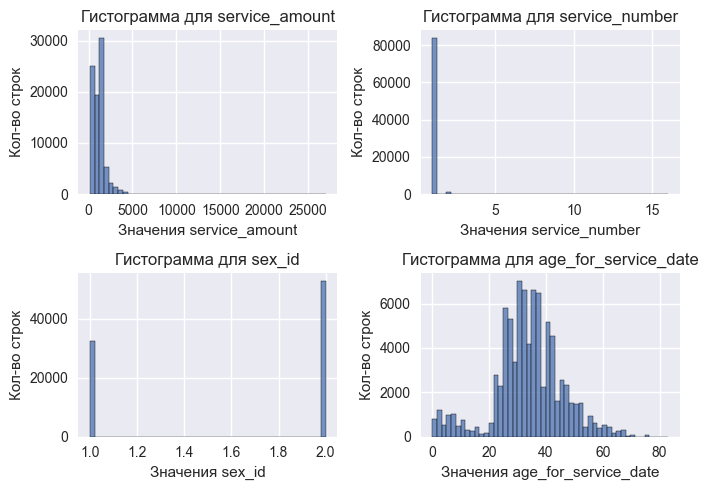

In [18]:
# гистограмма для всех числовых столбцов
num_list = ['service_amount', 'service_number', 'sex_id', 'age_for_service_date']
plt.figure(figsize=(7,5))
for i, col in enumerate(num_list):
    plt.subplot(2,2,i+1)
    sns.histplot(data=data, x=col, bins=50)
    plt.title(f'Гистограмма для {col}')
    plt.ylabel('Кол-во строк')
    plt.xlabel(f'Значения {col}')
    plt.tight_layout()
plt.show();

**Промежуточные выводы:** 
* необходимо изменить тип данных service_date на datetime
* проверить пропуски в столбце sex_id, а также обозначить какое число какому полу соответствует
* названия столбцов корректные
* большая часть услуг находится в диапазоне до 5000 р. Есть выбросы до 25000 руб, нужно оценить, реальны ли эти услуги
* большая часть пациентов возраста от 20 до 45 лет. Наблюдается провал для пациентов примерно от 14 до 20 лет, я думаю - это учащиеся средних-специальных и высших учебных заведений, как правило они прикреплены к клиникам учебных заведений
* колонка 'service_number' содержит практически одни единицы, значит услуги в 'service_name' в основном записаны обособленно, а не комплексно. Нужно оценить выбросы в количестве до 15 услуг

<a id='data_preparation'></a>
## 4. Предобработка данных

<a id='data_format'></a>
### 4.1. Изменение формата даты и добавления столбцов 'year' и 'month'

In [19]:
data['service_date'] = pd.to_datetime(data['service_date'])
start_data = data['service_date'].min()
end_data = data['service_date'].max()
print(f'Начало исследования: {start_data} \nКонец исследования: {end_data} ')

Начало исследования: 2021-01-03 00:00:00 
Конец исследования: 2022-08-31 00:00:00 


In [20]:
data['month'] = data['service_date'].dt.date.astype('datetime64[M]')
data['year'] = data['service_date'].dt.year
data['month_n'] = data['service_date'].dt.month
data['month_p'] = data['month'].dt.strftime('%Y-%m')

<a id='sex_id'></a>
### 4.2. Обработка пропусков в 'sex_id' и определение пола клиента

In [21]:
# заполнение пропусков по известному insured
print(data['sex_id'].unique())
data.loc[data['sex_id'].isna(), 'sex_id'] = (
    data.loc[data['sex_id'].isna(), 'insured'].map(data.groupby('insured')['sex_id'].first())
)
data[data['sex_id'].isna()]

[ 2.  1. nan]


record_id service_date     service_name  service_amount  \
8880   30620882903   2021-04-22  Прием первичный            1470   
8881   30620883003   2021-04-29  Прием повторный            1313   
12357  30786036703   2021-05-31  Прием первичный            1470   
17987  30961733903   2021-06-21  Прием повторный            1313   

       service_number  insured  sex_id  age_for_service_date      month  year  \
8880                1   221581     NaN                    42 2021-04-01  2021   
8881                1   221581     NaN                    42 2021-04-01  2021   
12357               1   221581     NaN                    42 2021-05-01  2021   
17987               1   221581     NaN                    42 2021-06-01  2021   

       month_n  month_p  
8880         4  2021-04  
8881         4  2021-04  
12357        5  2021-05  
17987        6  2021-06

In [22]:
# пропусков всего 4, можно удалить
data = data.dropna(subset=['sex_id']).reset_index(drop=True)

In [23]:
# проверка соответствия числа полу
data.loc[(data['service_name'].str.find('гинекол') != -1)].head()

record_id service_date  \
147  30268171703   2021-01-25   
272  30268184203   2021-01-22   
282  30268185203   2021-01-30   
359  30268192903   2021-01-26   
423  30268199303   2021-01-03   

                                          service_name  service_amount  \
147  Ультразвуковое исследование гинекология трансв...            2100   
272  Ультразвуковое исследование гинекология (сочет...            2625   
282  Ультразвуковое исследование гинекология трансв...            2100   
359  Ультразвуковое исследование гинекология трансв...            2100   
423  Ультразвуковое исследование гинекология трансв...            2100   

     service_number  insured  sex_id  age_for_service_date      month  year  \
147               1   535243   2.000                    38 2021-01-01  2021   
272               1   490772   2.000                    35 2021-01-01  2021   
282               1   243296   2.000                    51 2021-01-01  2021   
359               1   488030   2.000                    23 2021-01-01  2021   
423               1   530864   2.000                    24 2021-01-01  2021   

     month_n  month_p  
147        1  2021-01  
272        1  2021-01  
282        1  2021-01  
359        1  2021-01  
423        1  2021-01

In [24]:
data.loc[data['sex_id'] == 2, 'sex_id'] = 'женский'
data.loc[data['sex_id'] == 1, 'sex_id'] = 'мужской'


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85365 entries, 0 to 85364
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             85365 non-null  int64         
 1   service_date          85365 non-null  datetime64[ns]
 2   service_name          85365 non-null  object        
 3   service_amount        85365 non-null  int64         
 4   service_number        85365 non-null  int64         
 5   insured               85365 non-null  int64         
 6   sex_id                85365 non-null  object        
 7   age_for_service_date  85365 non-null  int64         
 8   month                 85365 non-null  datetime64[ns]
 9   year                  85365 non-null  int64         
 10  month_n               85365 non-null  int64         
 11  month_p               85365 non-null  object        
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 7.8+ MB


**Промежуточный вывод по 4.1 и 4.2.:** Пропуски убраны, типы данных изменены. Теперь нужно проверить на явные и неявные дубликаты. Неявные дубликаты могут быть только в 'service_name', так как только среди названий услуг клиники могут быть ошибочные символы и пр.

<a id='duplicates'></a>
### 4.3. Обработка явных и неявных дубликатов

In [26]:
print(f'Количество строк-дубликатов: {data.duplicated().sum()}')

Количество строк-дубликатов: 0


In [27]:
data['service_name'].unique()

array(['Прием первичный',
       'Взятие материала на посев, цитологическое исследование ( риноцитограмма)',
       'Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам',
       'Общий анализ крови (лейкоцитарная форм,, СОЭ)',
       'Ревматоидный фактор', 'С-реактивный белок',
       'Взятие крови из периферической вены', 'Магнитотерапия (1 сеанс)',
       'УВЧ-терапия (1 сеанс) (1 поле)', 'Прием повторный',
       'Смазывание глотки лекарственными формами', 'Взятие мазка',
       'Обработка вульвы', 'Обработка шейки матки',
       'Гинекологический мазок', 'Общий анализ мочи', 'Креатинин',
       'Мочевая кислота', 'Мочевина', 'Общий белок',
       'Ультразвуковое исследование почек и надпочечников',
       'Ультразвуковое исследование мочевого пузыря',
       'ЛПНП (липопротеиды низкой плотности, бета-липопротеиды)',
       'Триглицериды', 'Холестерин', 'АЛТ (аланинаминотрансфераза)',
       'Альдостерон', 'Кортизол (кровь)', 'Ренин + Ангио

In [28]:
# чтобы исключить дубликаты, связанные с запятыми, пробелами, 
# уберем их в начале и в конце строк (при наличии) и заменим их на '_'
data['service_name'] = data['service_name'].str.strip(' ')
data['service_name'] = data['service_name'].str.replace(', ', '_')
data['service_name'] = data['service_name'].str.replace(' ', '_')
data['service_name'] = data['service_name'].str.replace(',', '_')
data['service_name'] = data['service_name'].str.replace('__', '_')
data['service_name'] = data['service_name'].str.lower()

In [29]:
# повторная проверка на явные дубликаты
print(data.duplicated().sum())
data[data.duplicated(subset=['service_date', 'service_name', 'insured'])]

0


record_id service_date  \
93     30268166303   2021-01-05   
104    30268167403   2021-01-05   
143    30268171303   2021-01-21   
175    30268174503   2021-01-14   
177    30268174703   2021-01-15   
...            ...          ...   
80596  32978946303   2022-07-26   
81336  32979021003   2022-07-12   
83237  33177757403   2022-08-01   
84240  33177965603   2022-08-08   
85243  33178128703   2022-08-28   

                                            service_name  service_amount  \
93                                       прием_повторный            1313   
104                                      прием_первичный            1470   
143                                      прием_повторный            1313   
175                                      прием_первичный            1470   
177                                      прием_первичный            1470   
...                                                  ...             ...   
80596                     mycoplasma_genitalium_(соскоб)             400   
81336                взятие_крови_из_периферической_вены             187   
83237           исследование_отделяемого_молочной_железы            1000   
84240                                       взятие_мазка             792   
85243  в_мышечная_инъекция_(за_1_процедуру_без_стоимо...             320   

       service_number  insured   sex_id  age_for_service_date      month  \
93                  1   402409  женский                    36 2021-01-01   
104                 1   418179  мужской                    40 2021-01-01   
143                 1   166120  женский                    33 2021-01-01   
175                 1   534495  женский                    25 2021-01-01   
177                 1   221536  мужской                    35 2021-01-01   
...               ...      ...      ...                   ...        ...   
80596               1  1155124  женский                    40 2022-07-01   
81336               1   629910  женский                    40 2022-07-01   
83237               1  1302956  женский                    39 2022-08-01   
84240               2   935534  женский                    37 2022-08-01   
85243               1  1302824  женский                    39 2022-08-01   

       year  month_n  month_p  
93     2021        1  2021-01  
104    2021        1  2021-01  
143    2021        1  2021-01  
175    2021        1  2021-01  
177    2021        1  2021-01  
...     ...      ...      ...  
80596  2022        7  2022-07  
81336  2022        7  2022-07  
83237  2022        8  2022-08  
84240  2022        8  2022-08  
85243  2022        8  2022-08  

[1368 rows x 12 columns]

**Промежуточный вывод по 4.3.:** неявные дубликаты частично исключены, явных дубликатов- строк нет. Искать явные дубликаты сочетаний столбцов нет смысла, так как у одного и того же клиента в один день услуга может повторяться сколько угодно раз

<a id='service_category'></a>
### 4.4. Определение категорий услуг

In [98]:
print(f'Количество наименований услуг: {len(data["service_name"].unique())}')

Количество наименований услуг: 871


Наименований услуг очень много, чтобы как-то обрабатывать их, разобьем услуги на категории

In [30]:
# категоризация услуг
service_list = (
    {'прием_первичный_специалиста':['первичный', 'прием_психотерапевта', 'прием_психиатра', 'прием_отоневролога',
                                    'консультация_психолога', 'прием_врача_по_лечебной_физкультуре', 'консультация',
                                    'ведущего', 'эксперта', 'профессора', 'руководителя', 'до_мкад', 'за_мкад'],
     'прием_повторный_специалиста':['повторный'],
     'диагностика_и_лечение':['ультра', 'рентг', 'мрт', 'эхо', 'экг', 'ээг', 'метрия','отерапия', '-терапия', 
                              'терапия_(1_сеанс)', 'волновая_терапия', 'лфк', 'сканирование', 
                              'эзофагогастродуоденоскопия', 'осмотр', 'глазного', 'подбор', 'электрофорез',
                              'вестибулярных_тестов', 'электронейромиография', 'зрен', 'перевязка', 'гастроскопия',
                              'хирургическая', 'биопсия', 'колоноскопия'],
     'массаж_рефлексотерапия':['классический_лечебный_массаж', 'массаж_век', 'массаж_пояснично-крестцового',
                               'массаж_для_детей', 'мануальная_терапия', 'комплексная_мануальная_терапия', 
                               'сеанс_рефлексотерапии'],
     'анализы':['кров', 'антитела', 'igg', 'igm', 'посев', 'анализ', 'ige',
                'мазок', 'мазка', 'экспресс', 'кала', 'мочи', 'моча', 'белок', 'тромб', 'билирубин', 'пыльца']
    }
) 

In [31]:
def service_categories(purpose):
    for category, items_list in service_list.items():
        for item in items_list:
            if item in purpose:
                return category
    return 'остальное'

In [32]:
data['service_category'] = data['service_name'].apply(service_categories)

In [33]:
# проверка
data.query('service_category == "прием_повторный_специалиста"')['service_name'].unique()

array(['прием_повторный', 'прием_рефлексотерапевта_повторный',
       'прием_мануального_терапевта_повторный',
       'прием_травматолога-ортопеда_повторный', 'прием_уролога_повторный',
       'прием_терапевта_повторный', 'прием_гинеколога_повторный',
       'прием_эндокринолога_повторный', 'прием_педиатра_повторный',
       'прием_хирурга_повторный', 'прием_гастроэнтеролога_повторный',
       'прием_онколога_повторный', 'прием_невролога_повторный',
       'прием_отоларинголога_повторный', 'прием_физиотерапевта_повторный',
       'прием_дерматолога_повторный', 'прием_кардиолога_повторный',
       'прием_пульмонолога_повторный', 'прием_офтальмолога_повторный',
       'прием_аллерголога_повторный', 'прием_ревматолога_повторный',
       'прием_проктолога_повторный', 'прием_нефролога_повторный'],
      dtype=object)

Для анализа первичного и повторного приемов убираем информацию о специализации, и добавляем все в новый столбец

In [34]:
data['new_service_name'] = data['service_name'].apply(set_service)
data.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                        service_name  service_amount  \
0                                    прием_первичный            1470   
1  взятие_материала_на_посев_цитологическое_иссле...             284   
2  посев_отдел_дыхательных_путей_-_слизистая_зева...            1134   
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)             693   
4                                ревматоидный_фактор             420   

   service_number  insured   sex_id  age_for_service_date      month  year  \
0               1   490777  женский                    26 2021-01-01  2021   
1               1   490777  женский                    26 2021-01-01  2021   
2               1   490777  женский                    26 2021-01-01  2021   
3               1   490777  женский                    26 2021-01-01  2021   
4               1   490777  женский                    26 2021-01-01  2021   

   month_n  month_p             service_category  \
0        1  2021-01  прием_первичный_специалиста   
1        1  2021-01                      анализы   
2        1  2021-01                      анализы   
3        1  2021-01                      анализы   
4        1  2021-01                    остальное   

                                    new_service_name  
0                                    прием_первичный  
1  взятие_материала_на_посев_цитологическое_иссле...  
2  посев_отдел_дыхательных_путей_-_слизистая_зева...  
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)  
4                                ревматоидный_фактор

<a id='age_category'></a>
### 4.5. Определение возрастных категорий

Для того, чтобы обрабатывать данные о возрасте, разобьем его на категории

In [35]:
# Проверим, какие значения возрастов имеютя в данных, нет ли каких-нибудь аномалий:
print(f'Минимальный возраст пациента: {data["age_for_service_date"].min()}')
print(f'Минимальный возраст пациента: {data["age_for_service_date"].max()}')
data['age_for_service_date'].unique()

Минимальный возраст пациента: 0
Минимальный возраст пациента: 83


array([26, 25, 40, 35, 43, 48, 36,  2, 30,  1, 44, 32,  0, 28, 34,  4, 37,
       33, 38, 49, 45, 39, 51, 31, 23, 24, 27, 16,  5, 13, 42, 11, 29, 21,
        3, 65, 60,  6, 55, 68, 52, 47, 58,  8, 22, 50, 63,  7, 53, 62, 46,
       56,  9, 41, 61, 57, 14, 54, 10, 15, 18, 19, 12, 59, 17, 67, 83, 64,
       72, 20, 70, 66, 74, 75, 71, 69], dtype=int64)

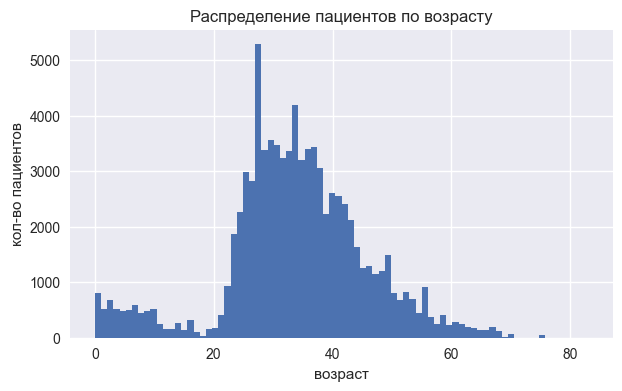

In [36]:
data['age_for_service_date'].hist(bins=80, figsize=(7,4))
plt.title('Распределение пациентов по возрасту')
plt.xlabel('возраст')
plt.ylabel('кол-во пациентов')
plt.show();

**Промежуточный вывод:** 
* нужно разделить пациентов на категории по возрасту
* самые больные — 34-летние пациенты, также пики в 25, 30, 37 лет — вот они кризисы разных возрастов
* очень мало пациентов возраста 11-17, а 18-летних практически нет. Обычно школьники и студенты проходят диспансеризацию в прикрепленых к своим учебным заведениям клиниках, а также в военкоматах

In [37]:
data['age_category'] = data['age_for_service_date'].apply(age_category)
data.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                        service_name  service_amount  \
0                                    прием_первичный            1470   
1  взятие_материала_на_посев_цитологическое_иссле...             284   
2  посев_отдел_дыхательных_путей_-_слизистая_зева...            1134   
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)             693   
4                                ревматоидный_фактор             420   

   service_number  insured   sex_id  age_for_service_date      month  year  \
0               1   490777  женский                    26 2021-01-01  2021   
1               1   490777  женский                    26 2021-01-01  2021   
2               1   490777  женский                    26 2021-01-01  2021   
3               1   490777  женский                    26 2021-01-01  2021   
4               1   490777  женский                    26 2021-01-01  2021   

   month_n  month_p             service_category  \
0        1  2021-01  прием_первичный_специалиста   
1        1  2021-01                      анализы   
2        1  2021-01                      анализы   
3        1  2021-01                      анализы   
4        1  2021-01                    остальное   

                                    new_service_name        age_category  
0                                    прием_первичный  25 <= возраст < 35  
1  взятие_материала_на_посев_цитологическое_иссле...  25 <= возраст < 35  
2  посев_отдел_дыхательных_путей_-_слизистая_зева...  25 <= возраст < 35  
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)  25 <= возраст < 35  
4                                ревматоидный_фактор  25 <= возраст < 35

**Промежуточный вывод по 4.5.:** 
* добавлена колонка категорий по возрасту

<a id='service_number'></a>
### 4.6. Расчет стоимости отдельной услуги

In [38]:
# просмотр строк, где колиество услуг >= 2
data.query('service_number >= 2')

record_id service_date  \
123    30268169303   2021-01-17   
178    30268174803   2021-01-15   
228    30268179803   2021-01-30   
402    30268197203   2021-01-04   
407    30268197703   2021-01-11   
...            ...          ...   
84888  33178074803   2022-08-08   
84889  33178074903   2022-08-08   
85071  33178104903   2022-08-03   
85072  33178105003   2022-08-03   
85173  33178119403   2022-08-30   

                                            service_name  service_amount  \
123                      удаление_серных_пробок_(за_ухо)            1324   
178                                         взятие_мазка             682   
228                                       рефрактометрия            1428   
402    взятие_материала_для_цитологического_исследования             568   
407                                       рефрактометрия            1428   
...                                                  ...             ...   
84888                удаление_ушной_серы_с_одной_стороны            1540   
84889  введение_лекарственных_препаратов_в_наружный_с...             616   
85071                удаление_ушной_серы_с_одной_стороны            1540   
85072                           туалет_слухового_прохода            1180   
85173                ультразвуковое_исследование_сустава            4360   

       service_number  insured   sex_id  age_for_service_date      month  \
123                 2   243480  мужской                    34 2021-01-01   
178                 2   221536  мужской                    35 2021-01-01   
228                 2   362887  женский                    31 2021-01-01   
402                 2   176388  женский                    39 2021-01-01   
407                 2   176388  женский                    39 2021-01-01   
...               ...      ...      ...                   ...        ...   
84888               2  1155162  женский                    47 2022-08-01   
84889               2  1155162  женский                    47 2022-08-01   
85071               2  1217359  мужской                    26 2022-08-01   
85072               2  1217359  мужской                    26 2022-08-01   
85173               2   873231  мужской                    38 2022-08-01   

       year  month_n  month_p       service_category  \
123    2021        1  2021-01              остальное   
178    2021        1  2021-01                анализы   
228    2021        1  2021-01  диагностика_и_лечение   
402    2021        1  2021-01              остальное   
407    2021        1  2021-01  диагностика_и_лечение   
...     ...      ...      ...                    ...   
84888  2022        8  2022-08              остальное   
84889  2022        8  2022-08              остальное   
85071  2022        8  2022-08              остальное   
85072  2022        8  2022-08              остальное   
85173  2022        8  2022-08  диагностика_и_лечение   

                                        new_service_name        age_category  
123                      удаление_серных_пробок_(за_ухо)  25 <= возраст < 35  
178                                         взятие_мазка  35 <= возраст < 45  
228                                       рефрактометрия  25 <= возраст < 35  
402    взятие_материала_для_цитологического_исследования  35 <= возраст < 45  
407                                       рефрактометрия  35 <= возраст < 45  
...                                                  ...                 ...  
84888                удаление_ушной_серы_с_одной_стороны  45 <= возраст < 55  
84889  введение_лекарственных_препаратов_в_наружный_с...  45 <= возраст < 55  
85071                удаление_ушной_серы_с_одной_стороны  25 <= возраст < 35  
85072                           туалет_слухового_прохода  25 <= возраст < 35  
85173                ультразвуковое_исследование_сустава  35 <= возраст < 45  

[1562 rows x 15 columns]

In [39]:
data['service_amount_one'] = data['service_amount'] / data['service_number']

**Промежуточный вывод по 4.6.:** из выведенной таблицы видно, что в столбце service_amount, во-первых, в основном записана сумма одной услуги, и только в 1562 строках из 85365 записано уже итоговое значение: стоимость услуги * количество услуг (service_number)
* поэтому добавим колонку service_amount_one, разделив service_amount на количество услуг. Все вычисления по отдельным услугам будем проводить по колонке service_amount_one, а вычисления по визиту по колонке service_amount

<a id='amount_category'></a>
### 4.7. Определение ценовых категорий

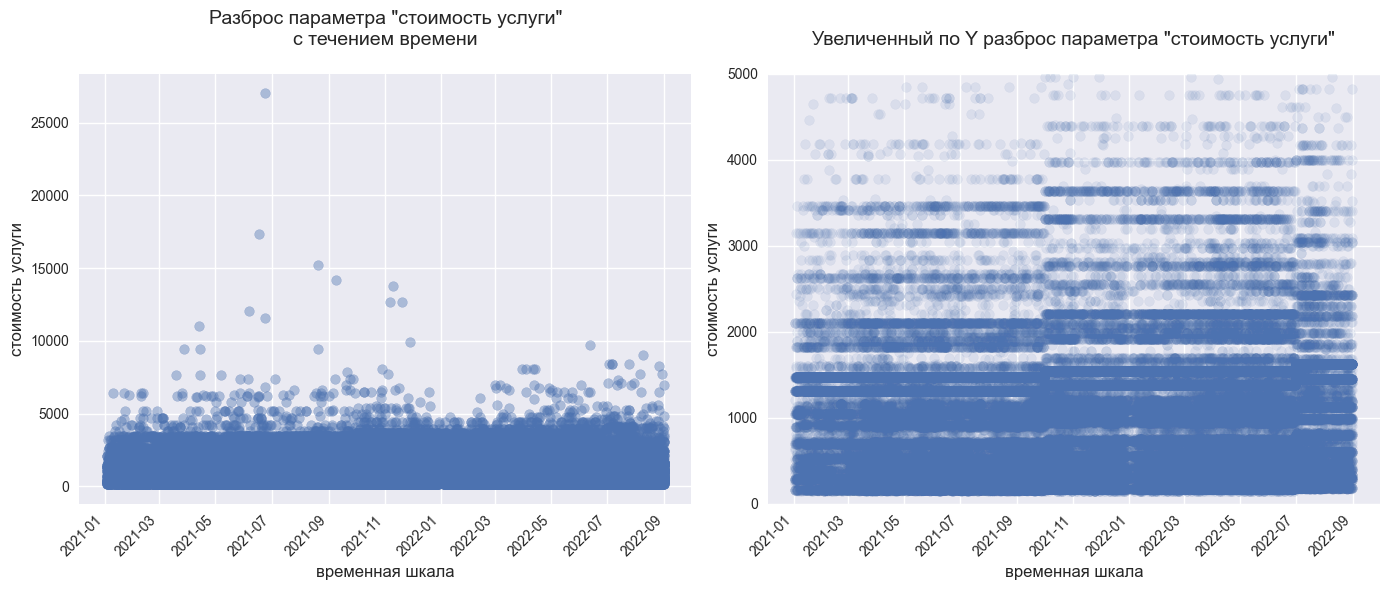

In [40]:
# вывод разброса стоимостей услуг в течение рассматриваемого периода
plot_scat(df=data, x='service_date', y='service_amount_one', a=5000)

In [41]:
# проверка значений выбросов
data.query('service_amount_one >=10000')

record_id service_date  \
8316   30620826503   2021-04-13   
15585  30961493203   2021-06-17   
16370  30961571703   2021-06-06   
18514  30961787003   2021-06-24   
18515  30961787103   2021-06-24   
23790  31249334503   2021-08-20   
27990  31408821503   2021-09-09   
36344  31680600903   2021-11-07   
36756  31680642403   2021-11-20   
37282  31680697303   2021-11-10   

                                            service_name  service_amount  \
8316   мскт_почек_и_надпочечников_с_внутривенным_болю...           11025   
15585  мрт_брюшной_полости_и_забрюшинного_пространств...           17325   
16370  мскт_мочевыделительной_системы_с_внутривенным_...           12075   
18514  тотальная_внутривенная_анестезия_от_20_минут_д...           11550   
18515               гистерорезектоскопия_при_полипах_рдв           26999   
23790  мрт_головного_мозга_и_гипофиза_с_контрастирова...           15225   
27990  мультипараметрическая_мрт_предстательной_желез...           14175   
36344  мскт_органов_брюшной_полости_и_забрюшинного_пр...           12680   
36756  мскт_органов_брюшной_полости_и_забрюшинного_пр...           12680   
37282  мрт_органов_малого_таза_с_внутривенным_контрас...           13780   

       service_number  insured   sex_id  age_for_service_date      month  \
8316                1   544444  мужской                    31 2021-04-01   
15585               1   634755  мужской                    41 2021-06-01   
16370               1   634765  мужской                    42 2021-06-01   
18514               1   362928  женский                    51 2021-06-01   
18515               1   362928  женский                    51 2021-06-01   
23790               1   544627  женский                    34 2021-08-01   
27990               1   531654  мужской                    59 2021-09-01   
36344               1   716141  женский                    31 2021-11-01   
36756               1   743829  мужской                    42 2021-11-01   
37282               1   596539  женский                    27 2021-11-01   

       year  month_n  month_p       service_category  \
8316   2021        4  2021-04              остальное   
15585  2021        6  2021-06  диагностика_и_лечение   
16370  2021        6  2021-06              остальное   
18514  2021        6  2021-06              остальное   
18515  2021        6  2021-06              остальное   
23790  2021        8  2021-08  диагностика_и_лечение   
27990  2021        9  2021-09  диагностика_и_лечение   
36344  2021       11  2021-11              остальное   
36756  2021       11  2021-11              остальное   
37282  2021       11  2021-11  диагностика_и_лечение   

                                        new_service_name        age_category  \
8316   мскт_почек_и_надпочечников_с_внутривенным_болю...  25 <= возраст < 35   
15585  мрт_брюшной_полости_и_забрюшинного_пространств...  35 <= возраст < 45   
16370  мскт_мочевыделительной_системы_с_внутривенным_...  35 <= возраст < 45   
18514  тотальная_внутривенная_анестезия_от_20_минут_д...  45 <= возраст < 55   
18515               гистерорезектоскопия_при_полипах_рдв  45 <= возраст < 55   
23790  мрт_головного_мозга_и_гипофиза_с_контрастирова...  25 <= возраст < 35   
27990  мультипараметрическая_мрт_предстательной_желез...  55 <= возраст < 65   
36344  мскт_органов_брюшной_полости_и_забрюшинного_пр...  25 <= возраст < 35   
36756  мскт_органов_брюшной_полости_и_забрюшинного_пр...  35 <= возраст < 45   
37282  мрт_органов_малого_таза_с_внутривенным_контрас...  25 <= возраст < 35   

       service_amount_one  
8316           11,025.000  
15585          17,325.000  
16370          12,075.000  
18514          11,550.000  
18515          26,999.000  
23790          15,225.000  
27990          14,175.000  
36344          12,680.000  
36756          12,680.000  
37282          13,780.000

In [42]:
# на основании графика разброса цен на услуги, разобьем услуги на ценовые категории
data['amount_category'] = data['service_amount_one'].apply(amount_category)
data.head()

record_id service_date  \
0  30268157003   2021-01-24   
1  30268157103   2021-01-24   
2  30268157203   2021-01-24   
3  30268157303   2021-01-24   
4  30268157403   2021-01-24   

                                        service_name  service_amount  \
0                                    прием_первичный            1470   
1  взятие_материала_на_посев_цитологическое_иссле...             284   
2  посев_отдел_дыхательных_путей_-_слизистая_зева...            1134   
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)             693   
4                                ревматоидный_фактор             420   

   service_number  insured   sex_id  age_for_service_date      month  year  \
0               1   490777  женский                    26 2021-01-01  2021   
1               1   490777  женский                    26 2021-01-01  2021   
2               1   490777  женский                    26 2021-01-01  2021   
3               1   490777  женский                    26 2021-01-01  2021   
4               1   490777  женский                    26 2021-01-01  2021   

   month_n  month_p             service_category  \
0        1  2021-01  прием_первичный_специалиста   
1        1  2021-01                      анализы   
2        1  2021-01                      анализы   
3        1  2021-01                      анализы   
4        1  2021-01                    остальное   

                                    new_service_name        age_category  \
0                                    прием_первичный  25 <= возраст < 35   
1  взятие_материала_на_посев_цитологическое_иссле...  25 <= возраст < 35   
2  посев_отдел_дыхательных_путей_-_слизистая_зева...  25 <= возраст < 35   
3        общий_анализ_крови_(лейкоцитарная_форм_соэ)  25 <= возраст < 35   
4                                ревматоидный_фактор  25 <= возраст < 35   

   service_amount_one                  amount_category  
0           1,470.000  1000 <= стоимость услуги < 2000  
1             284.000     0 <= стоимость услуги < 1000  
2           1,134.000  1000 <= стоимость услуги < 2000  
3             693.000     0 <= стоимость услуги < 1000  
4             420.000     0 <= стоимость услуги < 1000

**Промежуточный вывод:**
* услуги стоимостью >=10 т.р. — это реальные услуги, в основном хирургические операции и МРТ исследования.
* с января 2022 года данные дорогие услуги практически исчезли. В Июле они снова начали появляться (от 6000 до 8000 р.). Возможно это связано с проблемами с МРТ аппаратом, а также увольнением специалистов.
* по общей массе можно отметить скачок стоимости услуг в октябре 2021 года и июле 2022 года.


<a id='data_analysis'></a>
## 5. Исследовательский анализ данных

<a id='total_amount'></a>
### 5.1. Динамика выручки

Для начала посмотрим на динамику всей выручки по месяцам и годам
<a id='total_amount'></a>

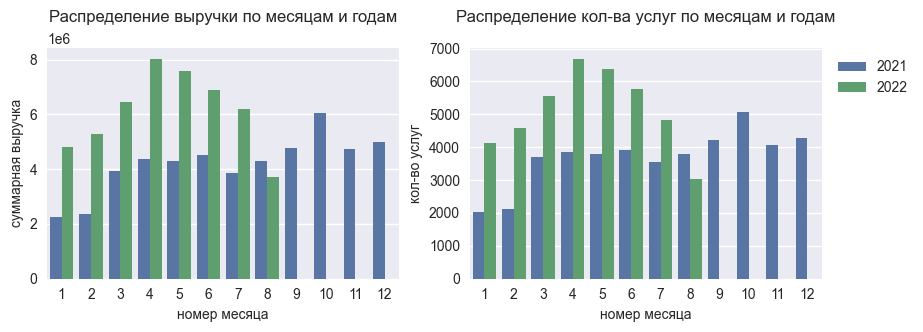

In [43]:
# расчет суммарной выручки по месяцам и сравнение 2021 года и 2022
# расчет кол-ва услуг по месяцам и сравнение 2021 года и 2022
data_month_service = data.groupby(['year','month_n'], as_index=False).agg({'service_amount':['sum','count']})
data_month_service.columns = data_month_service.columns.map('_'.join)
data_month_service = data_month_service.rename(columns={'year_':'year', 'month_n_':'month_n'})

plt.figure(figsize=(10,3))

ax1 = plt.subplot(1,2,1)
sns.barplot(data=data_month_service, x='month_n',y='service_amount_sum', hue='year')
plt.title('Распределение выручки по месяцам и годам\n', fontsize=12)
plt.xlabel('номер месяца', fontsize=10)
plt.ylabel('суммарная выручка', fontsize=10)
ax1.legend_.remove()

ax2 = plt.subplot(1,2,2)
sns.barplot(data=data_month_service, x='month_n',y='service_amount_count', hue='year')
plt.title('Распределение кол-ва услуг по месяцам и годам\n', fontsize=12)
plt.xlabel('номер месяца', fontsize=10)
plt.ylabel('кол-во услуг', fontsize=10)
plt.legend(bbox_to_anchor=(1.01, 1.0), fontsize=10)

plt.show()

In [44]:
print(f'Общая выручка за 2021 год (с 01 по 12 месяц): {data_month_service.query("year == 2021")["service_amount_sum"].sum()}')
print(f'Общая выручка за 2022 год (с 01 по 08 месяц): {data_month_service.query("year == 2022")["service_amount_sum"].sum()}')

Общая выручка за 2021 год (с 01 по 12 месяц): 50556105
Общая выручка за 2022 год (с 01 по 08 месяц): 48986662


In [45]:
# расчет разницы выручки по месяцам 2021 и 222 года, в %
data_amount = data.pivot_table(index='year', columns='month_n', values='service_amount', aggfunc=['sum', 'count']).fillna(0).T
data_amount.columns = ['2021', '2022']
data_amount['2022_/_2021_%'] = 100 * data_amount['2022'] / data_amount['2021'] - 100
data_amount

2021          2022  2022_/_2021_%
      month_n                                           
sum   1       2,265,931.000 4,800,320.000        111.848
      2       2,379,125.000 5,298,235.000        122.697
      3       3,927,248.000 6,451,060.000         64.264
      4       4,377,704.000 8,035,080.000         83.546
      5       4,297,508.000 7,588,110.000         76.570
      6       4,521,272.000 6,879,580.000         52.160
      7       3,872,209.000 6,216,498.000         60.541
      8       4,310,989.000 3,717,779.000        -13.760
      9       4,782,859.000         0.000       -100.000
      10      6,063,580.000         0.000       -100.000
      11      4,747,330.000         0.000       -100.000
      12      5,010,350.000         0.000       -100.000
count 1           2,021.000     4,143.000        104.998
      2           2,120.000     4,586.000        116.321
      3           3,696.000     5,547.000         50.081
      4           3,867.000     6,692.000         73.054
      5           3,787.000     6,374.000         68.313
      6           3,914.000     5,765.000         47.292
      7           3,545.000     4,841.000         36.559
      8           3,782.000     3,029.000        -19.910
      9           4,229.000         0.000       -100.000
      10          5,065.000         0.000       -100.000
      11          4,074.000         0.000       -100.000
      12          4,288.000         0.000       -100.000

**Промежуточный вывод по 5.1.:**
* несмотря на то, что 2022 год только до 08 месяца, его выручка практически равна выручке полного 2021 года
* зависимость динамики изменения выручки практически прямопропорциональна динамике изменения кол-ва услуг, но при этом за каждый месяц 2022 года до июня включительно выручка увеличилась на большее число процентов, чем количество услуг(на 7-10%).
* в июле же 2022 года выручка больше выручки 07.2021 на 60%, а количество услуг на 36,6%, это гворит о том, что услуги в 2022 году дороже, чем те же улуги в 2021 году.
* характер линии изменений кол-ва услуг и выручки по месцам в 2022 году такой же как и в 2021 с 01 по 07 месяцы. 
* Выделяется резкий скачок 04.2022 года (в 2021 лишь небольшой рост), а также падение 08.2022 (в 2021 году в августе наблюдается рост кол-ва услуг и выручки).


<a id='visits'></a>
### 5.2. Расчет визитов и средней стоимости услуг за визит

Визит — уникальное сочетание даты создания услуги и идентификатора застрахованного.

In [46]:
# группируем по дням и номерам застрахованнных, 
# для каждого застрахованного считаем количество услуг, которое он получил, 
# среднюю стоимость одной услуги за визит, и полную стоимость визита
visits_insured = (
    data.groupby(['service_date','insured'], as_index=False)
    .agg({'service_number':'sum', 'service_amount':['mean', 'sum'], 
          'sex_id':'last', 'age_category':'first', 
          'service_category':'first'})
) 
visits_insured.columns = visits_insured.columns.map('_'.join)
visits_insured = visits_insured.rename(columns={'service_date_':'service_date', 'insured_':'insured'})
visits_insured['week'] = visits_insured['service_date'].dt.date.astype('datetime64[W]')
visits_insured['month'] = visits_insured['service_date'].dt.date.astype('datetime64[M]')
visits_insured

service_date  insured  service_number_sum  service_amount_mean  \
0       2021-01-03   142427                   1            1,313.000   
1       2021-01-03   142562                   1            1,470.000   
2       2021-01-03   174009                   4              696.000   
3       2021-01-03   176359                   4            1,289.250   
4       2021-01-03   194308                   3              291.000   
...            ...      ...                 ...                  ...   
30285   2022-08-31  1303034                   1            1,620.000   
30286   2022-08-31  1303046                   3            2,726.667   
30287   2022-08-31  1306753                   3              815.333   
30288   2022-08-31  1306765                   3            2,160.000   
30289   2022-08-31  1306795                   1            1,620.000   

       service_amount_sum sex_id_last  age_category_first  \
0                    1313     мужской  25 <= возраст < 35   
1                    1470     мужской  35 <= возраст < 45   
2                    2784     мужской   0 <= возраст < 18   
3                    5157     женский  35 <= возраст < 45   
4                     873     женский  25 <= возраст < 35   
...                   ...         ...                 ...   
30285                1620     женский  18 <= возраст < 25   
30286                8180     мужской   0 <= возраст < 18   
30287                2446     женский  35 <= возраст < 45   
30288                6480     женский  25 <= возраст < 35   
30289                1620     мужской  25 <= возраст < 35   

            service_category_first       week      month  
0      прием_повторный_специалиста 2020-12-31 2021-01-01  
1      прием_первичный_специалиста 2020-12-31 2021-01-01  
2                          анализы 2020-12-31 2021-01-01  
3                          анализы 2020-12-31 2021-01-01  
4                        остальное 2020-12-31 2021-01-01  
...                            ...        ...        ...  
30285  прием_первичный_специалиста 2022-08-25 2022-08-01  
30286        диагностика_и_лечение 2022-08-25 2022-08-01  
30287  прием_повторный_специалиста 2022-08-25 2022-08-01  
30288  прием_первичный_специалиста 2022-08-25 2022-08-01  
30289  прием_первичный_специалиста 2022-08-25 2022-08-01  

[30290 rows x 10 columns]

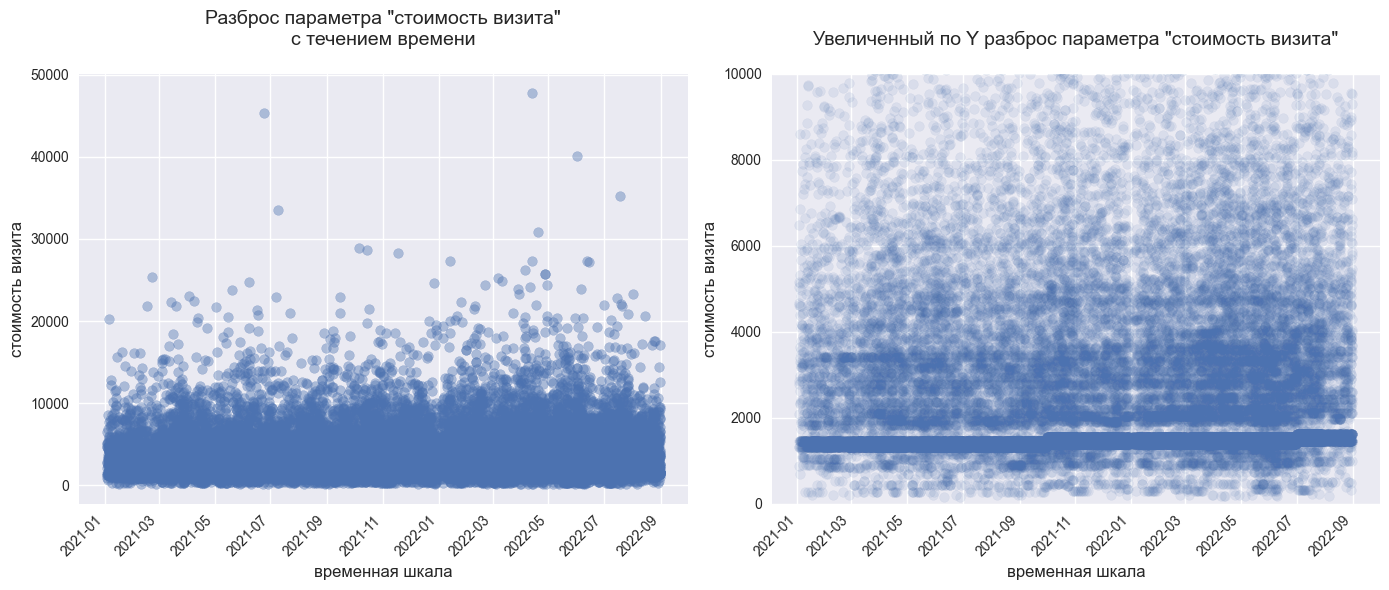

In [47]:
# построим разброс стоимостей визитов за весь рассматриваемый период
plot_scat(df=visits_insured, x='service_date', y='service_amount_sum', a=10000)

**Промежуточный вывод:**
* по общей массе можно отметить незначительное увеличение разброса стоимостей визитов с течением времени
* больше всего визитов стоимостью между 1500 и 1800 - очень похоже на один прием врача

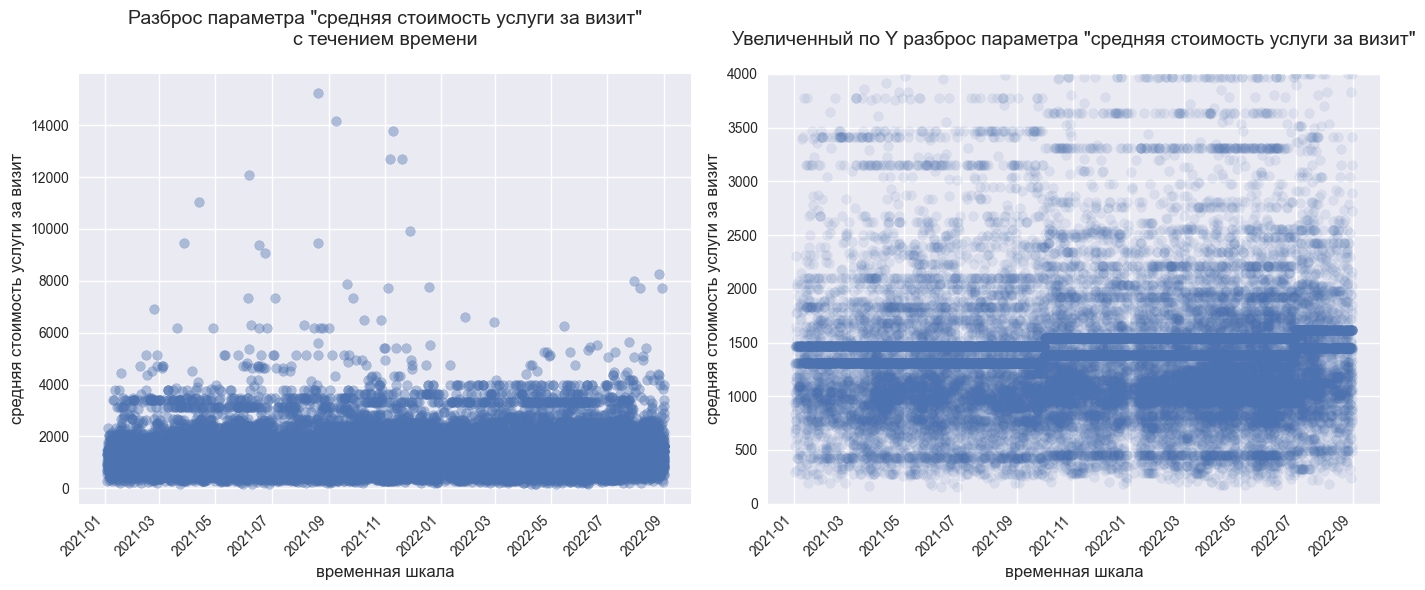

In [48]:
# построим разброс средней стоимости услуги за визит за весь рассматриваемый период
plot_scat(df=visits_insured, x='service_date', y='service_amount_mean', a=4000)

**Промежуточный вывод:**
* по общей массе можно также отметить повышение средней стоимости самых распространенных услуг за визит в октябре 2021 и июле 2022 года. Рассморим детальное изменение цен на самые распространенные услуги далее.
* распространенные услуги за визит: ~500, ~1300-1500, ~1800-1900, ~2100-2200, 3200-3500

In [49]:
# расчитаем количество визитов, их среднюю стоимость и среднее количество услуг за визит в клинике за каждый день
visits_day = (
    visits_insured.groupby('service_date')
    .agg({'insured':'count', 'service_amount_sum':'mean', 'service_number_sum':'mean'})
)
visits_day['year'] = visits_day.index
visits_day['year'] = visits_day['year'].dt.year
visits_day

insured  service_amount_sum  service_number_sum  year
service_date                                                       
2021-01-03         12           3,222.167               4.083  2021
2021-01-04         19           3,335.895               2.947  2021
2021-01-05         28           3,713.893               3.821  2021
2021-01-06         23           2,510.261               2.696  2021
2021-01-07         20           2,909.150               2.600  2021
...               ...                 ...                 ...   ...
2022-08-27         26           3,206.077               3.038  2022
2022-08-28         24           2,573.875               2.042  2022
2022-08-29         42           3,676.262               3.214  2022
2022-08-30         36           3,603.028               2.861  2022
2022-08-31         45           4,001.333               3.289  2022

[602 rows x 4 columns]

In [50]:
print(f'Количество визитов в 2021 году (с 01 по 12 месяц): {visits_day.query("year == 2021")["insured"].sum()}')
print(f'Количество визитов в 2022 году (с 01 по 08 месяц): {visits_day.query("year == 2022")["insured"].sum()}')

Количество визитов в 2021 году (с 01 по 12 месяц): 15856
Количество визитов в 2022 году (с 01 по 08 месяц): 14434


In [51]:
# применяем функцию сглаживания для исключения шумов
visits_day = filter_data(visits_day, 'insured', 7)
visits_day = filter_data(visits_day, 'service_amount_sum', 7)
visits_day = filter_data(visits_day, 'service_number_sum', 7)

<a id='visits_count_day'><a/>

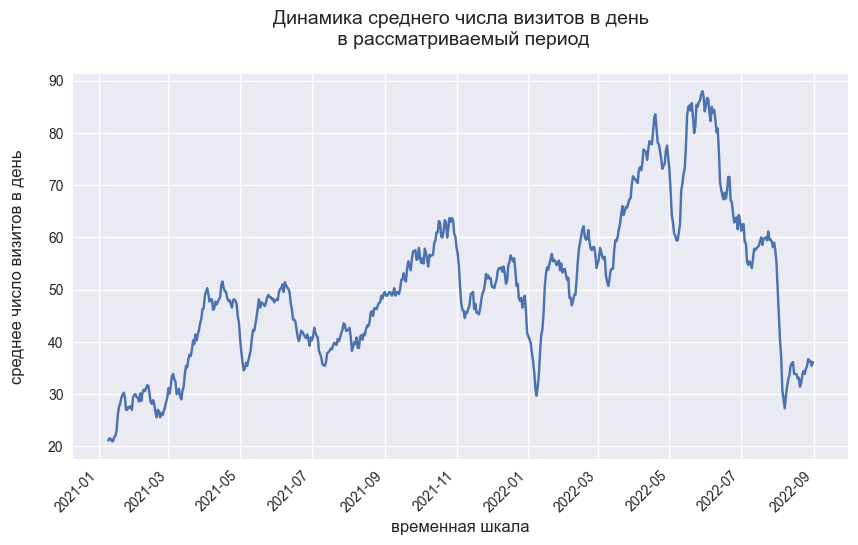

In [52]:
# строим динамику количества визитов в день
plot_line(df=visits_day, y='insured')

**Промежуточный вывод:** 
* в рассматриваемый период число визитов в день росло, за исключением государственных праздников и выходных, в которые наблюдаются падения количества визитов и периода 12.21-01.22, в который наблюдается снижение визитов, скорее всего из-за зимних отпусков
* начиная с июня 2022 года и до конца наблюдения (31.08.2021) непрерывное падение количества визитов, хотя в аналогичный период 2021 года после падения в июне 2021 года количество визитов растет

<a id='mean_cost_visit'><a/>

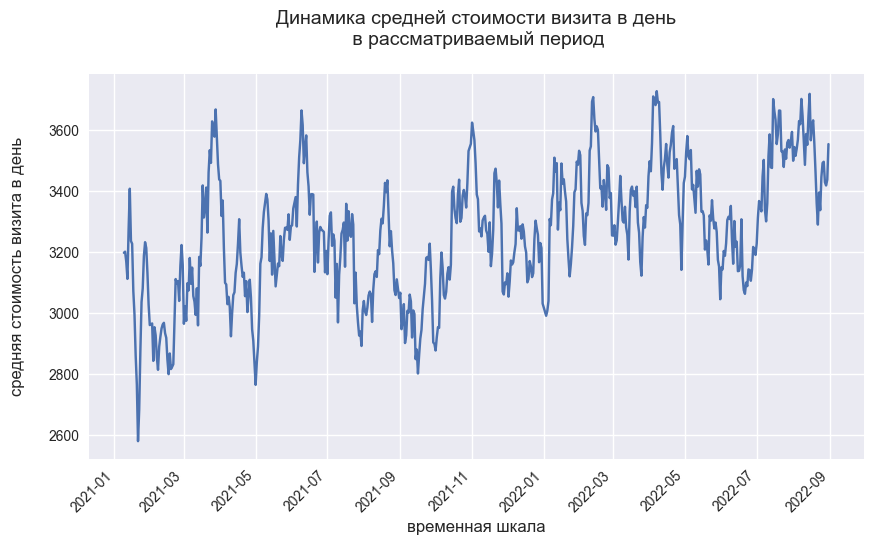

In [53]:
# строим динамику средней стоимости визита в день
plot_line(df=visits_day, y='service_amount_sum')

**Промежуточный вывод:**
* средняя стоимость визита увеличивается

<a id='mean_count_service'><a/>

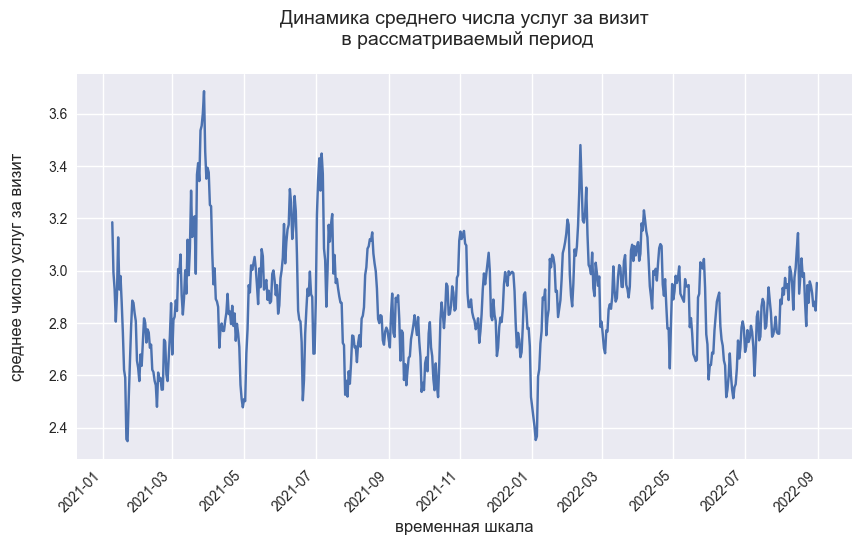

In [54]:
# строим динамику среднего количества услуг за визит в день
plot_line(df=visits_day, y='service_number_sum')

**Промежуточный вывод:**
* наблюдается снижение разброса среднего количества услуг за визит в день

**Промежуточный вывод по 5.2.**
* несмотря на то положительную, то отрицательную динамику изменения количества визитов в день, средняя стоимость визита в течение рассматриваемого периода увеличивается, а разброс среднего количества услуг за визит уменьшается, хотя в целом срднее число количесвта услуг за визит остается где-то между 2.8 и 3.0

<a id='visits_month'></a>
### 5.3. Расчет обратившихся в месяц

Обратившийся в месяц — уникальное сочетание месяца оказания услуги и идентификатора застрахованного.

In [55]:
# расчитаем количество обратившихся в месяц в клинике за каждый месяц
unique_visits_month = (
    data.pivot_table(index=['month'], values=['insured'], aggfunc=['nunique', 'count'])
)
unique_visits_month.columns = unique_visits_month.columns.map('_'.join)
unique_visits_month

nunique_insured  count_insured
month                                     
2021-01-01              286           2021
2021-02-01              309           2120
2021-03-01              446           3696
2021-04-01              466           3867
2021-05-01              468           3787
2021-06-01              434           3914
2021-07-01              447           3545
2021-08-01              488           3782
2021-09-01              559           4229
2021-10-01              591           5065
2021-11-01              539           4074
2021-12-01              560           4288
2022-01-01              555           4143
2022-02-01              589           4586
2022-03-01              662           5547
2022-04-01              794           6692
2022-05-01              802           6374
2022-06-01              738           5765
2022-07-01              641           4841
2022-08-01              359           3029

<a id='count_insured_month'><a/>

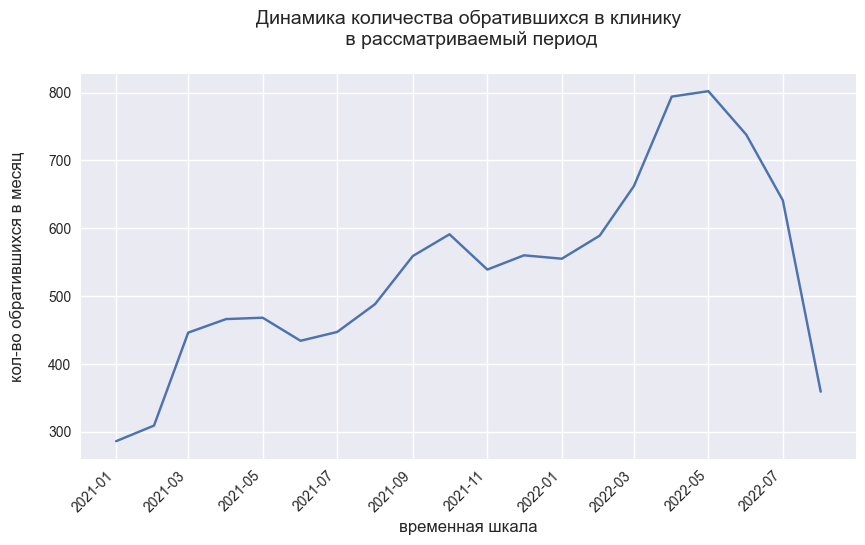

In [56]:
# строим динамику количесвта обратившихся в клинику в месяц
plot_line(df=unique_visits_month, y='nunique_insured')

**Промежуточный вывод по 5.3.:**

* в рассматриваемый период количество обратившихся в месяц плавно растет, достигает пика  мае 2022 и падает до конца августа. Динамика похожа на сглаженую динамику визитов по неделям
* при этом количество обратившихся в месяц за 06-07.2022 еще больше, чем в 2021, но в августе 2022 уже меньше, чем в 2022
* в ноябре 2021 года наблюдается спад визитов, возможно связано с мобилизацией, возможно сезонное падение, но данных за другие года нет, поэтому можно только предполагать
* одинаковый спад на новогодние праздники и в 2021, и 2022 году - можно отнести к сезонному характеру
* июнь-август 2021 года показывает рост и визитов, и обратившихся в месяц, в 2022 — быстрое падение

<a id='visit_1'></a>
### 5.4. Оценка пациентов с точки зрения "разовых" и "постоянных" клиентов

Рассмотрим, сколько всего застрахованных посетило клинику

In [57]:
# для каждого 'insured' считаем количество уникальных визитов и месяцев с визитами
insured_unique = (
    data.groupby(['insured'], as_index=False)
    .agg({'service_date':'nunique', 'month':'nunique'})
    .sort_values(by='service_date')
)
insured_unique

insured  service_date  month
1695   627743             1      1
1646   608178             1      1
1643   603909             1      1
3911  1073394             1      1
3914  1073404             1      1
...       ...           ...    ...
159    180725            73      8
1772   634801            75      9
681    402409            75     17
711    418193            78     11
845    490750            94     15

[4487 rows x 3 columns]

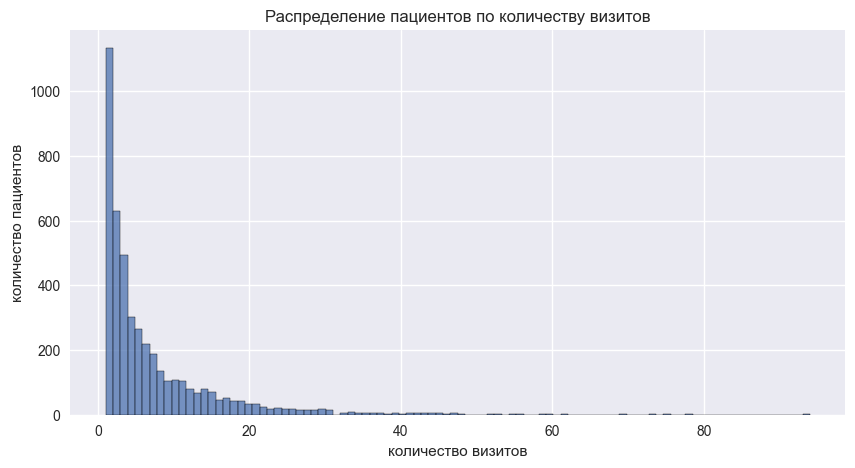

In [58]:
plt.figure(figsize=(10,5))
sns.histplot(data=insured_unique, x='service_date')
plt.title('Распределение пациентов по количеству визитов')
plt.xlabel('количество визитов')
plt.ylabel('количество пациентов')
plt.show();

In [59]:
# выведем процентное отношение пациентов по количеству посещений
insured_unique['service_date'].value_counts(normalize=True)

1    0.253
2    0.140
3    0.110
4    0.067
5    0.059
6    0.048
7    0.042
8    0.030
10   0.024
11   0.023
9    0.023
12   0.018
14   0.018
15   0.015
13   0.015
17   0.011
16   0.010
19   0.009
18   0.009
21   0.008
20   0.007
22   0.006
24   0.005
25   0.004
26   0.004
23   0.004
30   0.004
29   0.004
31   0.003
27   0.003
28   0.003
33   0.002
44   0.001
34   0.001
36   0.001
39   0.001
32   0.001
37   0.001
43   0.001
35   0.001
47   0.001
42   0.001
41   0.001
45   0.001
56   0.001
38   0.001
62   0.000
53   0.000
69   0.000
75   0.000
48   0.000
40   0.000
52   0.000
78   0.000
73   0.000
46   0.000
94   0.000
55   0.000
59   0.000
60   0.000
Name: service_date, dtype: float64

**Промежуточный вывод:**
* всего клинику посетило 4487 пациента
* 25% застрахованных посетило клиниику только один раз. Расссмотрим их поподробней, так как 1/4 часть от всех пациентов - это довольно много
* 25% застрахованных посетило клиниику 2-3 раза
* оставшиеся 50% пациентов посетило клинику от 4 до 94 раз


In [60]:
# вытаскиваем пациентов, которые пришли в клинику только раз
insured_list = insured_unique.query('service_date == 1')['insured']
data_1 = data.query('insured in @insured_list')
rate_1 = data_1["service_amount"].sum()/data["service_amount"].sum()
print(f'Выручка от "разовых" посетителей в рассматриваемый период: {data_1["service_amount"].sum()}')
print(f'Выручка в рассматриваемый период по всем данным: {data["service_amount"].sum()}')
print(f'Доля от общей выручки, которую принесли "разовые" пациениты: {rate_1:.3%}')

Выручка от "разовых" посетителей в рассматриваемый период: 3496131
Выручка в рассматриваемый период по всем данным: 99542767
Доля от общей выручки, которую принесли "разовые" пациениты: 3.512%


<a id='one_time_insured'><a/>

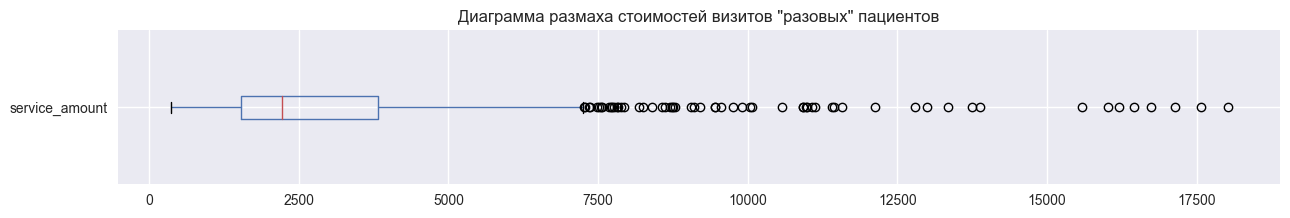

count    1,133.000
mean     3,085.729
std      2,364.520
min        360.000
25%      1,540.000
50%      2,220.000
75%      3,830.000
max     18,018.000
Name: service_amount, dtype: float64

In [61]:
# оценка стоимости визитов "разовых" пациентов
visit_1 = data_1.groupby('insured', as_index=False)['service_amount'].sum()
(
    visit_1.boxplot(column='service_amount', figsize=(15,2), vert = False)
    .set_title('Диаграмма размаха стоимостей визитов "разовых" пациентов')
)

plt.show()
visit_1['service_amount'].describe()

**Промежуточный вывод по 5.4.:**
* по медианному значению можно предположить, что "разовый" визит — это прием врача и какие-то анализы. Есть небольшое кол-во выбросов, которые показывают стоимсоть визитов, в которых комплекс услуг
* всего 3,5% от всей выручки от 25% пациентов - это незначительно, поэтому дальше "разовых" пациентов рассматривать не будем
* основную выручку принесли пациенты, которые приходили более 1 раза

<a id='top_10'></a>
### 5.5. Динамика изменения стоимости самых популярных услуг по месяцам

#### Процентное соотношение количества услуг по категориям за каждый месяц

<a id='rate_service_cat'><a/>

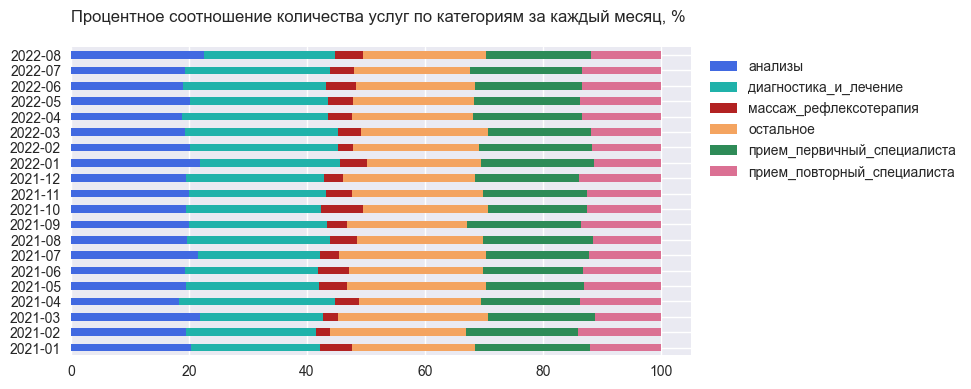

In [62]:
# ежемесячное распределение категорий услуг
data_ser_cat = (
    data.pivot_table(
        index='month_p',
        columns='service_category',
        values='service_amount_one',
        aggfunc='count'
    ).T
)

# перевод в проценты от общего числа услуг за каждый месяц:

for column in data_ser_cat.columns:
    a = data_ser_cat[column].sum()
    for index in data_ser_cat.index:
        data_ser_cat.loc[index, column] = 100 * (data_ser_cat.loc[index, column] / a)

colors=["royalblue", "lightseagreen", "firebrick", "sandybrown", "seagreen", "palevioletred"]        
data_ser_cat.T.plot(kind='barh', stacked=True, figsize=(8,4), color=colors)
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.01, 1.0), fontsize=10)
plt.title(f'Процентное соотношение количества услуг по категориям за каждый месяц, % \n', fontsize=12)
plt.show()

**Промежуточный вывод:**
* распределение услуг по категориям за каждый месяц с течением времени практически не меняется
* в целом количество услуг первичный_прием и повторный_прием составляет около 30% от всех услуг в каждый месяц
* можно отметить, что первичных приемов больше, чем повторных

#### Динамика изменения стоимости популярных услуг по категориям:

<a id='sex_id_service'><a/>

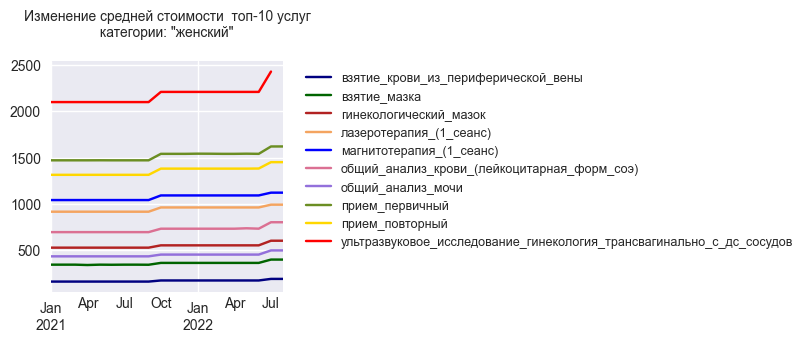


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены                                    0.155
взятие_мазка                                                           0.139
гинекологический_мазок                                                 0.125
лазеротерапия_(1_сеанс)                                                0.077
магнитотерапия_(1_сеанс)                                               0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)                            0.134
общий_анализ_мочи                                                      0.129
прием_первичный                                                        0.093
прием_повторный                                                        0.094
ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов     NaN
dtype: float64


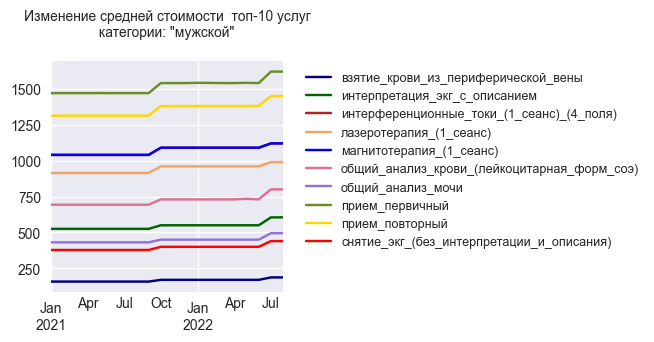


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
интерпретация_экг_с_описанием                 0.132
интерференционные_токи_(1_сеанс)_(4_поля)     0.071
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
снятие_экг_(без_интерпретации_и_описания)     0.141
dtype: float64


In [63]:
# по полу пациента 'sex_id'
for dimension in data['sex_id'].unique():
    rise_service = plot_top_10(data, dimension, 'sex_id')
    print(rise_service)

**Промежуточный вывод по категории "sex_id":**
* систематическое повышение стоимости почти всех услуг 10.2021 и 07.2022. Некоторые анализы выросли на 15%, более дорогие исследвания на 7-8%, приемы врачей на 10%
* ценовой диапазон топ-10 услуг пациентов мужского и женского пола почти одинаков: ~ от 200 до 1600, только у пациентов женского пола есть еще одна популярная услуга в ценовом диапазоне от 2000 до 2500


<a id='amount_cat_service'><a/>

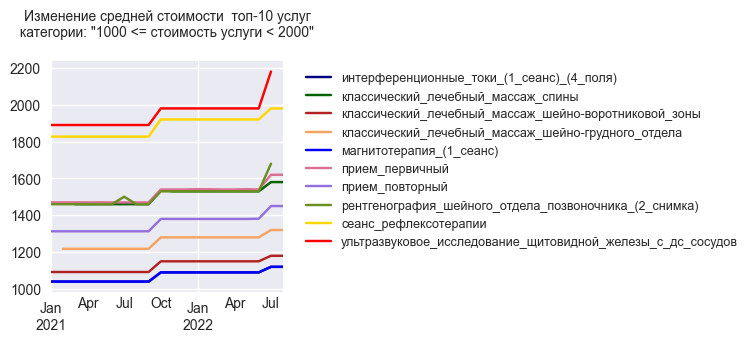


Разница средней стоимости услуги 08.2022 относительно 01.2021

интерференционные_токи_(1_сеанс)_(4_поля)                    0.071
классический_лечебный_массаж_спины                           0.076
классический_лечебный_массаж_шейно-воротниковой_зоны         0.075
классический_лечебный_массаж_шейно-грудного_отдела             NaN
магнитотерапия_(1_сеанс)                                     0.071
прием_первичный                                              0.093
прием_повторный                                              0.094
рентгенография_шейного_отдела_позвоночника_(2_снимка)          NaN
сеанс_рефлексотерапии                                        0.077
ультразвуковое_исследование_щитовидной_железы_с_дс_сосудов     NaN
dtype: float64


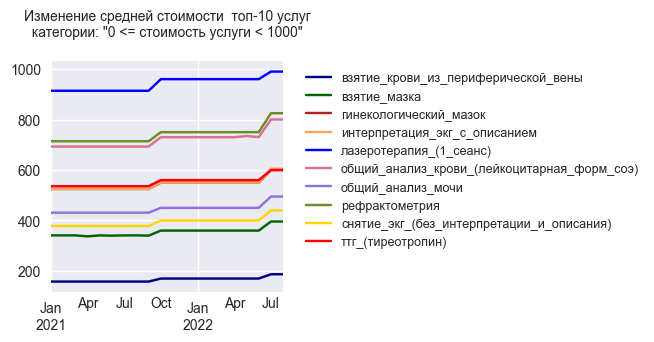


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
взятие_мазка                                  0.139
гинекологический_мазок                        0.125
интерпретация_экг_с_описанием                 0.132
лазеротерапия_(1_сеанс)                       0.077
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
рефрактометрия                                0.135
снятие_экг_(без_интерпретации_и_описания)     0.141
ттг_(тиреотропин)                             0.107
dtype: float64


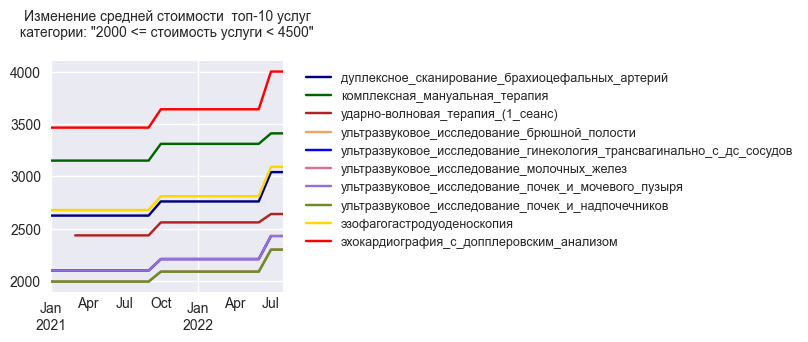


Разница средней стоимости услуги 08.2022 относительно 01.2021

дуплексное_сканирование_брахиоцефальных_артерий                        0.137
комплексная_мануальная_терапия                                         0.076
ударно-волновая_терапия_(1_сеанс)                                        NaN
ультразвуковое_исследование_брюшной_полости                            0.136
ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов     NaN
ультразвуковое_исследование_молочных_желез                             0.133
ультразвуковое_исследование_почек_и_мочевого_пузыря                    0.136
ультразвуковое_исследование_почек_и_надпочечников                      0.133
эзофагогастродуоденоскопия                                             0.133
эхокардиография_с_допплеровским_анализом                               0.134
dtype: float64


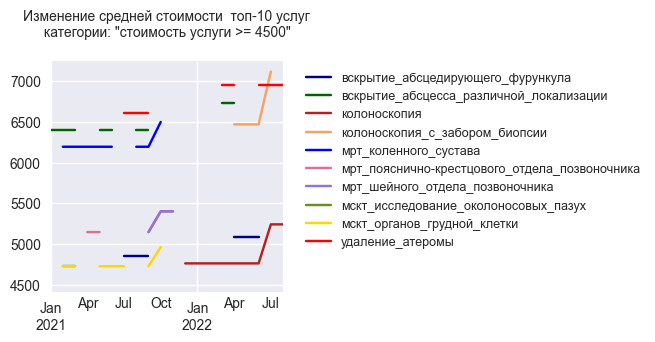


Разница средней стоимости услуги 08.2022 относительно 01.2021

вскрытие_абсцедирующего_фурункула               NaN
вскрытие_абсцесса_различной_локализации         NaN
колоноскопия                                    NaN
колоноскопия_с_забором_биопсии                  NaN
мрт_коленного_сустава                           NaN
мрт_пояснично-крестцового_отдела_позвоночника   NaN
мрт_шейного_отдела_позвоночника                 NaN
мскт_исследование_околоносовых_пазух            NaN
мскт_органов_грудной_клетки                     NaN
удаление_атеромы                                NaN
dtype: float64


In [64]:
# по стоимости услуги 'amount_category'
for dimension in data['amount_category'].unique():
    rise_service = plot_top_10(data, dimension, 'amount_category')
    print(rise_service)

**Промежуточный вывод по категории "amount_category":**
* систематическое повышение стоимости почти всех услуг 10.2021 и 07.2022
* отличается характер изменения цен для топ-10 услуг из категорий:
  * ценовая категория "0 <= стоимость услуги < 1000": в данной категории стоимость услуг выросла от 8 до 16%
  * ценовая категория "1000 <= стоимость услуги < 2000": в данной категории стоимость услуг выросла от 7 до 10%
  * ценовая категория "2000 <= стоимость услуги < 4500": в данной категории стоимость услуг выросла от 8 до 14%
  * ценовая категория "стоимость услуги >= 4500": видно, что с 10.2021 многие услуги пропали вообще, или предоставлялись лишь изредка


<a id='service_cat_service'><a/>

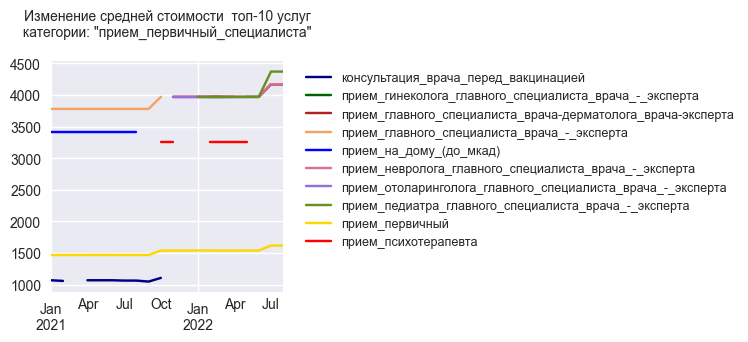


Разница средней стоимости услуги 08.2022 относительно 01.2021

консультация_врача_перед_вакцинацией                            NaN
прием_гинеколога_главного_специалиста_врача_-_эксперта          NaN
прием_главного_специалиста_врача-дерматолога_врача-эксперта     NaN
прием_главного_специалиста_врача_-_эксперта                     NaN
прием_на_дому_(до_мкад)                                         NaN
прием_невролога_главного_специалиста_врача_-_эксперта           NaN
прием_отоларинголога_главного_специалиста_врача_-_эксперта      NaN
прием_педиатра_главного_специалиста_врача_-_эксперта            NaN
прием_первичный                                               0.093
прием_психотерапевта                                          0.091
dtype: float64


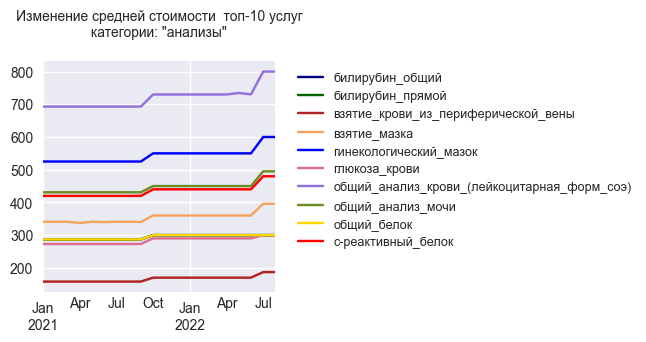


Разница средней стоимости услуги 08.2022 относительно 01.2021

билирубин_общий                               0.043
билирубин_прямой                              0.043
взятие_крови_из_периферической_вены           0.155
взятие_мазка                                  0.139
гинекологический_мазок                        0.125
глюкоза_крови                                 0.090
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
общий_белок                                   0.043
с-реактивный_белок                            0.125
dtype: float64


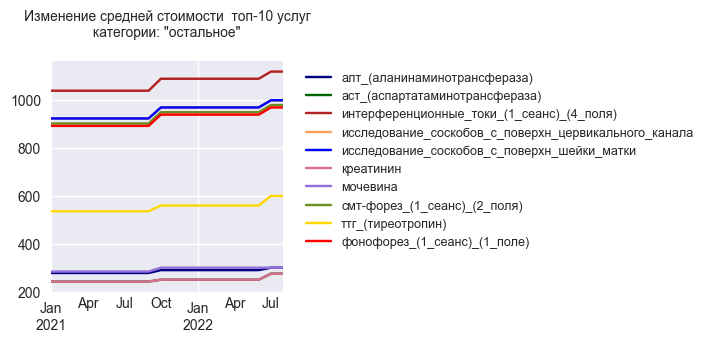


Разница средней стоимости услуги 08.2022 относительно 01.2021

алт_(аланинаминотрансфераза)                           0.073
аст_(аспартатаминотрансфераза)                         0.120
интерференционные_токи_(1_сеанс)_(4_поля)              0.071
исследование_соскобов_с_поверхн_цервикального_канала   0.076
исследование_соскобов_с_поверхн_шейки_матки            0.076
креатинин                                              0.120
мочевина                                               0.053
смт-форез_(1_сеанс)_(2_поля)                           0.079
ттг_(тиреотропин)                                      0.107
фонофорез_(1_сеанс)_(1_поле)                           0.079
dtype: float64


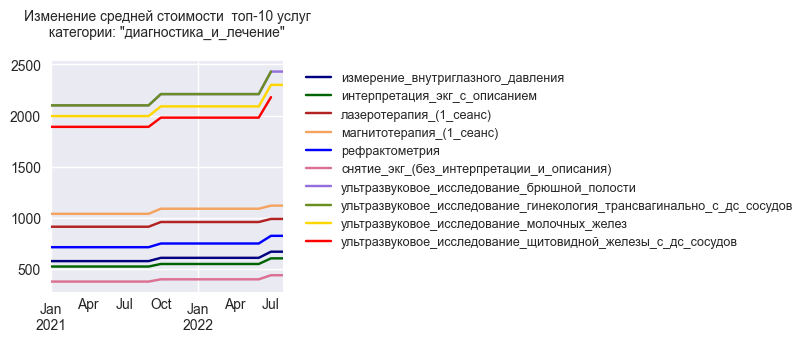


Разница средней стоимости услуги 08.2022 относительно 01.2021

измерение_внутриглазного_давления                                      0.137
интерпретация_экг_с_описанием                                          0.132
лазеротерапия_(1_сеанс)                                                0.077
магнитотерапия_(1_сеанс)                                               0.071
рефрактометрия                                                         0.135
снятие_экг_(без_интерпретации_и_описания)                              0.141
ультразвуковое_исследование_брюшной_полости                            0.136
ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов     NaN
ультразвуковое_исследование_молочных_желез                             0.133
ультразвуковое_исследование_щитовидной_железы_с_дс_сосудов               NaN
dtype: float64


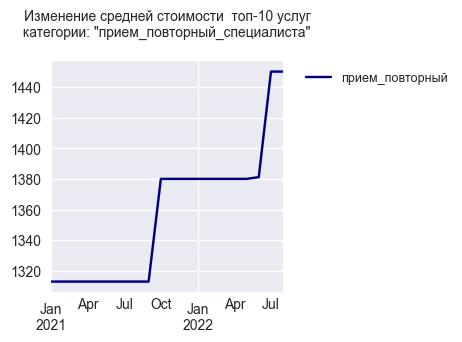


Разница средней стоимости услуги 08.2022 относительно 01.2021

прием_повторный   0.094
dtype: float64


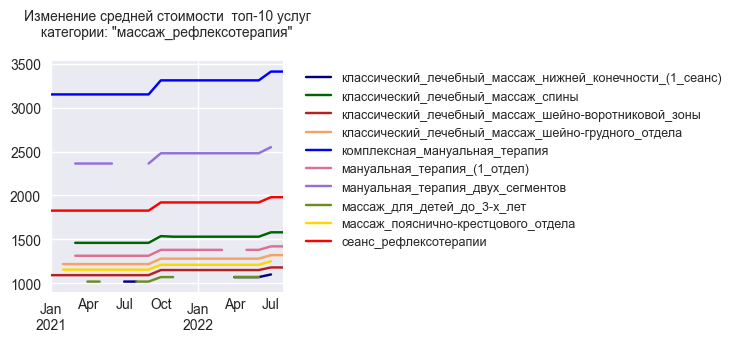


Разница средней стоимости услуги 08.2022 относительно 01.2021

классический_лечебный_массаж_нижней_конечности_(1_сеанс)     NaN
классический_лечебный_массаж_спины                         0.076
классический_лечебный_массаж_шейно-воротниковой_зоны       0.075
классический_лечебный_массаж_шейно-грудного_отдела           NaN
комплексная_мануальная_терапия                             0.076
мануальная_терапия_(1_отдел)                               0.075
мануальная_терапия_двух_сегментов                            NaN
массаж_для_детей_до_3-х_лет                                  NaN
массаж_пояснично-крестцового_отдела                          NaN
сеанс_рефлексотерапии                                      0.077
dtype: float64


In [65]:
# по категории услуги 'service_category'
for dimension in data['service_category'].unique():
    rise_service = plot_top_10(data, dimension, 'service_category')
    print(rise_service)


**Промежуточный вывод по категории "service_category":**
* систематическое повышение стоимости почти всех услуг 10.2021 и 07.2022
* отличается характер изменения цен для некторых услуг из категорий: 
  * прием_первичный_специалиста: до 10.2021 года были такие услуги как консультация врача перед вакцинацией, а также выезд врача на дом, после 10.2021 года этих услуг уже нет. Я думаю, что они связаны с ковидными мерами
  * в конце исследования пропали популярные услуги ультразвуковое_исследование_щитовидной_железы_с_дс_сосудо и ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов. Возможно сломалось оборудование или уволились специалисты 


<a id='age_cat_service'><a/>

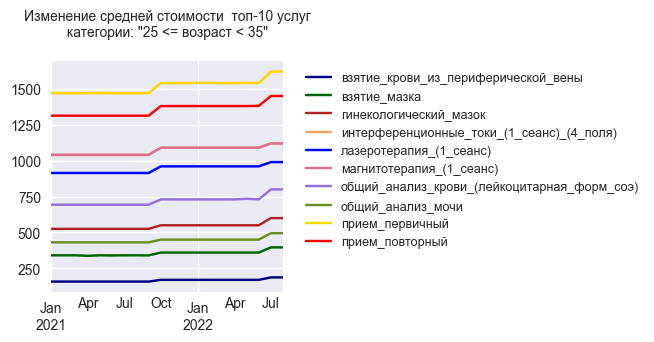


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
взятие_мазка                                  0.139
гинекологический_мазок                        0.125
интерференционные_токи_(1_сеанс)_(4_поля)     0.071
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
dtype: float64


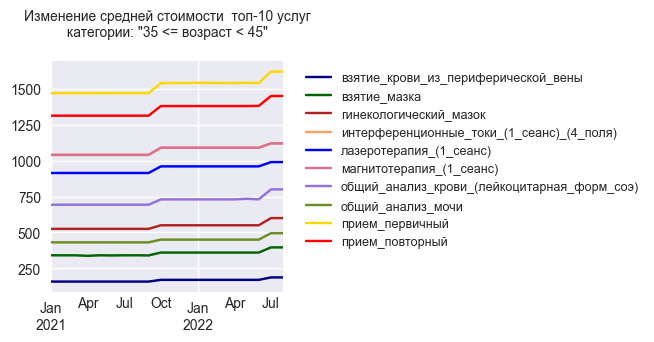


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
взятие_мазка                                  0.139
гинекологический_мазок                        0.125
интерференционные_токи_(1_сеанс)_(4_поля)     0.071
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
dtype: float64


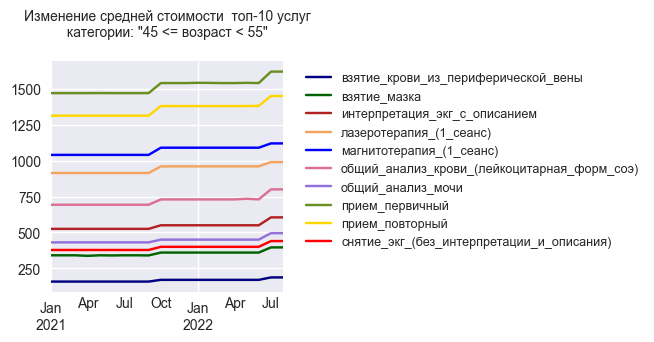


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
взятие_мазка                                  0.139
интерпретация_экг_с_описанием                 0.132
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
снятие_экг_(без_интерпретации_и_описания)     0.141
dtype: float64


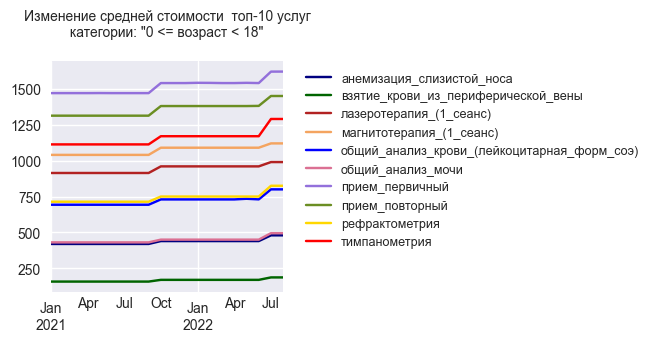


Разница средней стоимости услуги 08.2022 относительно 01.2021

анемизация_слизистой_носа                     0.125
взятие_крови_из_периферической_вены           0.155
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
рефрактометрия                                0.135
тимпанометрия                                 0.137
dtype: float64


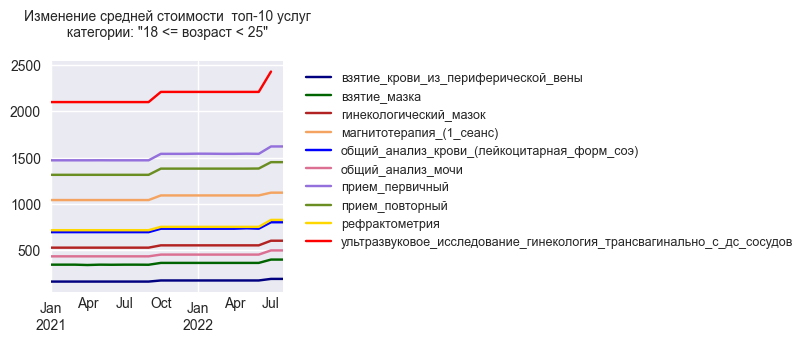


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены                                    0.155
взятие_мазка                                                           0.139
гинекологический_мазок                                                 0.125
магнитотерапия_(1_сеанс)                                               0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)                            0.134
общий_анализ_мочи                                                      0.129
прием_первичный                                                        0.093
прием_повторный                                                        0.094
рефрактометрия                                                         0.135
ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов     NaN
dtype: float64


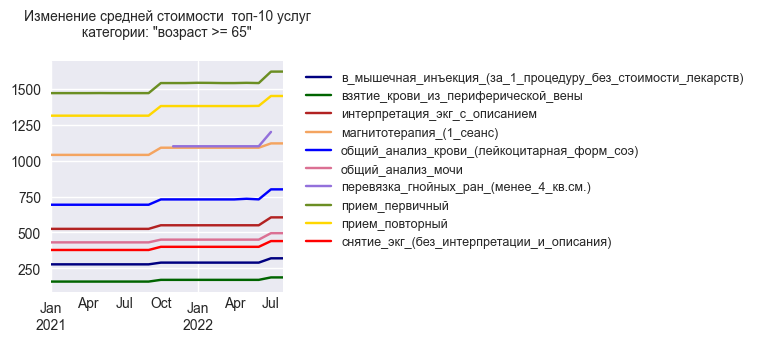


Разница средней стоимости услуги 08.2022 относительно 01.2021

в_мышечная_инъекция_(за_1_процедуру_без_стоимости_лекарств)   0.131
взятие_крови_из_периферической_вены                           0.155
интерпретация_экг_с_описанием                                 0.132
магнитотерапия_(1_сеанс)                                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)                   0.134
общий_анализ_мочи                                             0.129
перевязка_гнойных_ран_(менее_4_кв.см.)                          NaN
прием_первичный                                               0.093
прием_повторный                                               0.094
снятие_экг_(без_интерпретации_и_описания)                     0.141
dtype: float64


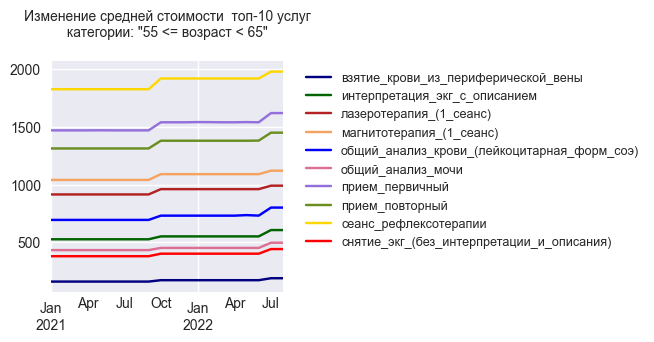


Разница средней стоимости услуги 08.2022 относительно 01.2021

взятие_крови_из_периферической_вены           0.155
интерпретация_экг_с_описанием                 0.132
лазеротерапия_(1_сеанс)                       0.077
магнитотерапия_(1_сеанс)                      0.071
общий_анализ_крови_(лейкоцитарная_форм_соэ)   0.134
общий_анализ_мочи                             0.129
прием_первичный                               0.093
прием_повторный                               0.094
сеанс_рефлексотерапии                         0.077
снятие_экг_(без_интерпретации_и_описания)     0.141
dtype: float64


In [66]:
# по возрасту 'age_category'
for dimension in data['age_category'].unique():
    rise_service = plot_top_10(data, dimension, 'age_category')
    print(rise_service)

**Промежуточный вывод по категории "age_category":**
* систематическое повышение стоимости почти всех услуг 10.2021 и 07.2022
* в целом ценовой диапазон топ-10 популярных услуг почти для каждой возрастной категории один и тот же: ~ от 200 до 1600. Отличаются только категория "55 <= возраст < 65" — добавилась услуга сеанс_рефлексотерапии, и "18 <= возраст < 25" — ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов


**Промежуточный обобщающий вывод по топ-10 услугам (5.5.):**
* в целом средняя стоимость на самые популярные услуги в рассматриваемый период меняласась 2 раза: 10.2021 и 07.2022
* можно рассмотреть распределение пациентов по полу в возрастной категории 
* графики показали, что некоторые популярные услуги пропали 08.2022
* услуги дороже 4500 не являются популярными услугами в клинике

<a id='med_case'></a>
### 5.6. Медицинский кейс

Медицинский кейс клиники — последовательность медицинских услуг, полученных одним застрахованным с интервалом между любыми соседними по дате услугами не более 14 дней

In [67]:
# определение для каждого застрахованного: дней визитов, количества полученных услуг в каждый визит, 
# а также общая сумма, которую пациент заплатил за визит
insureds = (
    data.groupby(['insured', 'service_date'], as_index=False)
    .agg({'sex_id':'first', 'age_category':'first', 'service_amount': ['sum', 'count']})
) 
insureds.columns = ['insured', 'service_date', 'sex_id', 'age_category', 'sum_amount', 'cnt_service']
insureds.head()

insured service_date   sex_id   age_category  sum_amount  cnt_service
0   125073   2021-01-11  женский  возраст >= 65        2321            3
1   125073   2021-01-16  женский  возраст >= 65        1827            1
2   125073   2021-01-17  женский  возраст >= 65        3813            2
3   125073   2021-01-23  женский  возраст >= 65        1313            1
4   125073   2021-09-21  женский  возраст >= 65        2940            2

In [68]:
# считаем разницу между визитами кажого пациента
for i in range(1, insureds.shape[0]):    
    if insureds.loc[i, 'insured'] == insureds.loc[i-1, 'insured']:
        insureds.loc[i, 'time_delta'] = (
                insureds.loc[i, 'service_date'] - insureds.loc[i-1, 'service_date'])
    elif insureds.loc[i, 'insured'] != insureds.loc[i-1, 'insured']:
        continue
insureds.head()        

insured service_date   sex_id   age_category  sum_amount  cnt_service  \
0   125073   2021-01-11  женский  возраст >= 65        2321            3   
1   125073   2021-01-16  женский  возраст >= 65        1827            1   
2   125073   2021-01-17  женский  возраст >= 65        3813            2   
3   125073   2021-01-23  женский  возраст >= 65        1313            1   
4   125073   2021-09-21  женский  возраст >= 65        2940            2   

  time_delta  
0        NaT  
1     5 days  
2     1 days  
3     6 days  
4   241 days

In [69]:
insureds['time_delta'] = insureds['time_delta'].dt.days
insureds.head()

insured service_date   sex_id   age_category  sum_amount  cnt_service  \
0   125073   2021-01-11  женский  возраст >= 65        2321            3   
1   125073   2021-01-16  женский  возраст >= 65        1827            1   
2   125073   2021-01-17  женский  возраст >= 65        3813            2   
3   125073   2021-01-23  женский  возраст >= 65        1313            1   
4   125073   2021-09-21  женский  возраст >= 65        2940            2   

   time_delta  
0         NaN  
1       5.000  
2       1.000  
3       6.000  
4     241.000

In [70]:
# определяем медицинские кейсы по разницам между визитами 'time_delta'
j = 1
insureds.loc[0, 'med_case'] = j

for i in range(1, insureds.shape[0]):    
    if (insureds.loc[i, 'insured'] == insureds.loc[i-1, 'insured'] and
    insureds.loc[i, 'time_delta'] <= 14):
        insureds.loc[i, 'time_delta_in_case'] = insureds.loc[i, 'time_delta']
        insureds.loc[i, 'med_case'] = insureds.loc[i-1, 'med_case']
    elif (insureds.loc[i, 'insured'] == insureds.loc[i-1, 'insured'] and
    insureds.loc[i, 'time_delta'] > 14):
        insureds.loc[i, 'time_delta_in_case'] = 0
        insureds.loc[i, 'med_case'] = insureds.loc[i-1, 'med_case'] + 1        
    elif insureds.loc[i, 'insured'] != insureds.loc[i-1, 'insured']:
        insureds.loc[i, 'med_case'] = insureds.loc[i-1, 'med_case'] + 1
    else:
        continue


In [71]:
insureds.tail()

insured service_date   sex_id        age_category  sum_amount  \
30285  1306795   2022-08-18  мужской  25 <= возраст < 35        6107   
30286  1306795   2022-08-24  мужской  25 <= возраст < 35        7510   
30287  1306795   2022-08-27  мужской  25 <= возраст < 35        4000   
30288  1306795   2022-08-28  мужской  25 <= возраст < 35        1450   
30289  1306795   2022-08-31  мужской  25 <= возраст < 35        1620   

       cnt_service  time_delta  med_case  time_delta_in_case  
30285            7       1.000 8,959.000               1.000  
30286            4       6.000 8,959.000               6.000  
30287            1       3.000 8,959.000               3.000  
30288            1       1.000 8,959.000               1.000  
30289            1       3.000 8,959.000               3.000

In [72]:
# расчет стоимости медицинского кейса и количества входящих в него услуг
med_case = (
    insureds.groupby(['med_case'], as_index=False)
    .agg({'service_date':['first', 'count'], 'time_delta':'sum', 'sum_amount':'sum', 
          'cnt_service':'sum', 'insured':'first', 'sex_id':'first', 'age_category': 'first'})
) 

med_case.columns = (
    ['med_case', 'dt_first', 'visits_cnt', 'total_days', 'sum_amount', 'cnt_service', 'insured', 'sex_id', 'age_category']
) 
med_case['med_case'] = med_case['med_case'].astype('int')
med_case['total_days'] = med_case['total_days'].astype('int')
med_case.head()

med_case   dt_first  visits_cnt  total_days  sum_amount  cnt_service  \
0         1 2021-01-11           4          12        9274            7   
1         2 2021-09-21           6         255       16246           13   
2         3 2021-11-16           5          54        7560            7   
3         4 2021-01-22           2           7        4479            4   
4         5 2021-10-06           2         255       15280            9   

   insured   sex_id        age_category  
0   125073  женский       возраст >= 65  
1   125073  женский       возраст >= 65  
2   125073  женский       возраст >= 65  
3   125094  женский  35 <= возраст < 45  
4   125094  женский  35 <= возраст < 45

In [73]:
# добавляем вспомогательные временные столбцы
med_case['month_n'] = med_case['dt_first'].dt.month
med_case['year'] = med_case['dt_first'].dt.year
med_case['month'] = med_case['dt_first'].dt.date.astype('datetime64[M]')
med_case['week'] = med_case['dt_first'].dt.date.astype('datetime64[W]')
med_case['week_n'] = med_case['dt_first'].dt.isocalendar().week
med_case['month_p'] = med_case['month'].dt.strftime('%Y-%m')

# сортировка по дате начала медицинского кейса
med_case = med_case.sort_values(by='dt_first')
med_case.head()

med_case   dt_first  visits_cnt  total_days  sum_amount  cnt_service  \
271        272 2021-01-03           2           2        4097            5   
3007      3008 2021-01-03           5           5       10722           11   
40          41 2021-01-03           3           3        7320            5   
996        997 2021-01-03          12          29       32853           29   
299        300 2021-01-03           6          37       26784           20   

      insured   sex_id        age_category  month_n  year      month  \
271    174009  мужской   0 <= возраст < 18        1  2021 2021-01-01   
3007   530752  женский  45 <= возраст < 55        1  2021 2021-01-01   
40     142562  мужской  35 <= возраст < 45        1  2021 2021-01-01   
996    243321  женский  35 <= возраст < 45        1  2021 2021-01-01   
299    176359  женский  35 <= возраст < 45        1  2021 2021-01-01   

           week  week_n  month_p  
271  2020-12-31      53  2021-01  
3007 2020-12-31      53  2021-01  
40   2020-12-31      53  2021-01  
996  2020-12-31      53  2021-01  
299  2020-12-31      53  2021-01

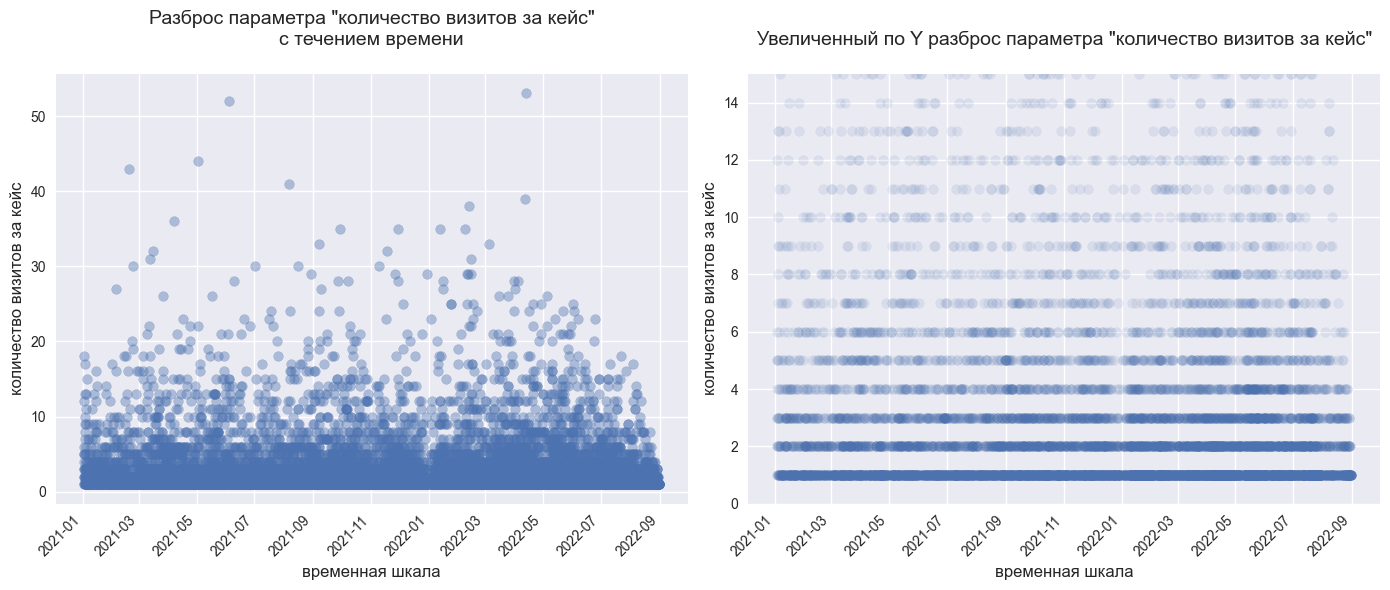

In [99]:
# выведем разброс количества визитов за кейс за весь рассматриваемый период
plot_scat(df=med_case, x='dt_first', y='visits_cnt', a=15)

<a id='med_case_fig'></a>

**Промежуточный вывод по 5.6.:**
* характер распределения медицинских кейсов по количеству визитов — обратно пропорционален количеству визитов за кейс: больше всего кейсов с одним визитом (практически 50%) и наоборот — меньшего всего кейсов в с большим количеством визитов
* в рассматриваемый период не наблюдается тендеции увеличения числа визитов за кейс, просто увеличивается число кейсов и с одним визитом, и с большим количеством визитов
* рассматривать выручку по кейсу нецелесообразно, так как она приходит в клинику в течении всего кейса за каждый визит отдельно
* также часть медицинских кейсов, стартовавших или имевших очередной визит во второй половине августа еще не окончена, так как мы не знаем, будет ли следующий визит в сентябре или нет

<a id='total_amount_category'></a>
### 5.7. Оценка зависимости выручки от различных категорий

Проверям, зависит ли выручка от таких категорий как: 
* пол пациента: 'sex_id'
* возраст пациента: 'age_category'
* количества услуг по типу: 'service_category'
* количества услуг по ценовой категории: 'amount_category'

#### 5.7.1. Пол пациента: 'sex_id'

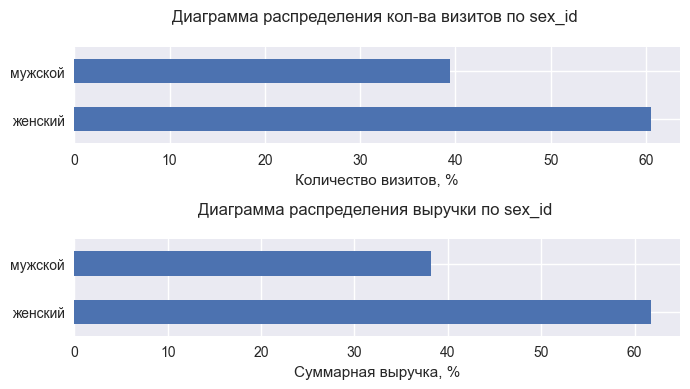

insured  service_amount  insured/ total, %  service_amount/ total, %
sex_id                                                                       
женский    18336        61495444             60.535                    61.778
мужской    11954        38047323             39.465                    38.222

In [75]:
# выведем общую выручку и количество пациентов с разделением по полу пациента
plot_group(data, 'sex_id')

**Промежуточный вывод: за весь рассматриваемый период**
* Пациенты женского пола принесли в ~1,6 раза больше выручки, чем пациенты мужского пола, но и количество пациентов женского пола больше, чем пациентов мужского пола в ~ 1,5
* Проверим, выше ли средняя стоимость визита пациентов женского пола среднего чека пациентов мужского пола

**Гипотеза 5.7.1.1**
* Нулевая гипотеза: средний чек за визит пациентов женского пола равен среднему чеку за визит пациентов мужского пола
* Альтернативная гипотеза: средний чек за визит пациентов женского пола больше, чем средний чек за визит пациентов мужского пола

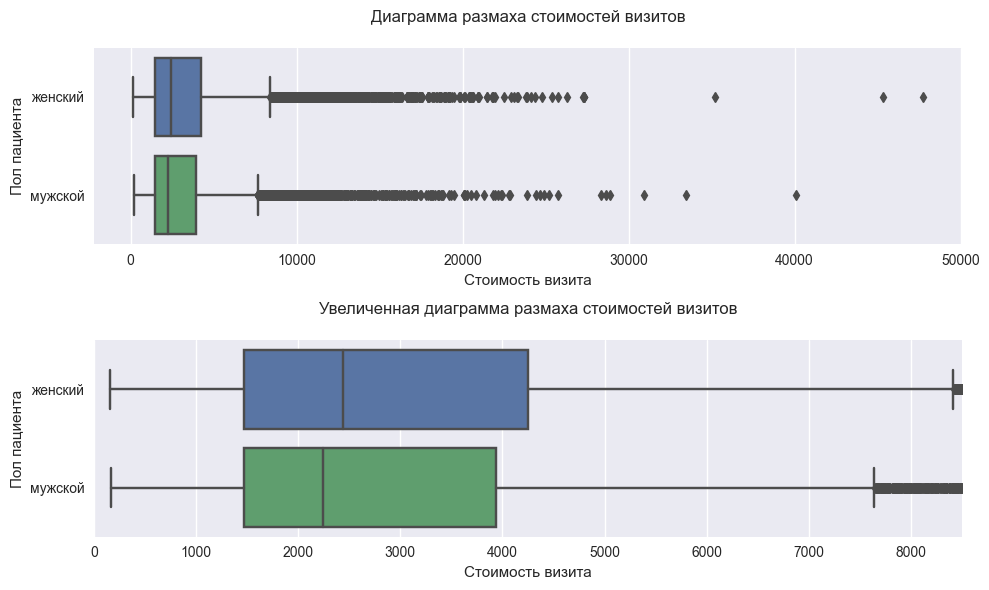

In [78]:
# используем таблицу visits_insured, которю рассчитали в части 5.2. при рассчете визитов
# выведем диаграммы размаха стоимостей визитов с разделением по полу пациента
boxplot_cat(df=visits_insured, column='sex_id_last', a=8500)

**Выбираем критерий t-test, так как:**
* выборки достаточно большие
* выборки независимые
* в выборках нет экстремально больших значений

In [79]:
# уровень значимости
alpha = 0.05
results = (
    st.ttest_ind(visits_insured_s.query('sex_id_last == "женский"')['service_amount_sum'], 
                 visits_insured_s.query('sex_id_last == "мужской"')['service_amount_sum'],
                 equal_var=False, alternative='greater')
) 
print(f'p-value: {results.pvalue:}')
# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    print('Средний чек пациентов женского пола: ',
          visits_insured_s.query('sex_id_last == "женский"')['service_amount_sum'].median())
    print('Средний чек пациентов мужского пола: ', 
          visits_insured_s.query('sex_id_last == "мужской"')['service_amount_sum'].median())
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.7359670930933544e-10
Отвергаем нулевую гипотезу
Средний чек пациентов женского пола:  2430.0
Средний чек пациентов мужского пола:  2216.0


**Промежуточный вывод по влиянию пола пацента на выручку (по 5.7.1.)**
* так как мы отвергли нулевую гипотезу о равенстве среднего чека визита пациентов мужского и женского пола, то можно считать, что пациенты женского пола принесли выручки больше пациентов мужского пола не только потому, что их больше, чем пациентов мужского пола, но и потому, что средний чек пациентов женского пола выше, чем средний чек пациентов мужского пола
* диаграмма размаха также подтверждает медианные значения: визит пациентов женского пола "дороже" (=2430) визита пациентов мужского пола (=2216)

<a id='amount_sex_id'><a/>

#### 5.7.2. Возраст пациента: 'age_category'

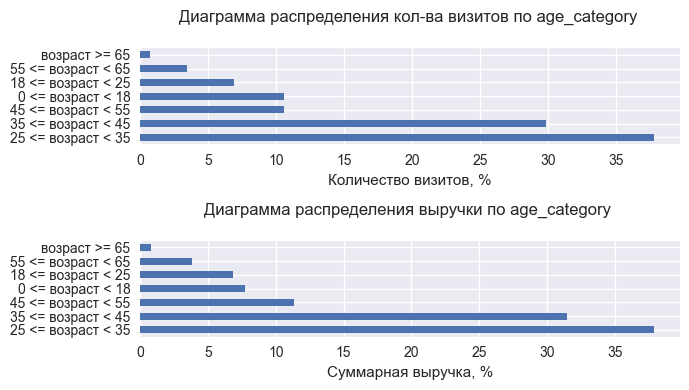

insured  service_amount  insured/ total, %  \
age_category                                                     
25 <= возраст < 35    11457        37732988             37.824   
35 <= возраст < 45     9055        31296855             29.894   
45 <= возраст < 55     3199        11321083             10.561   
0 <= возраст < 18      3212         7714961             10.604   
18 <= возраст < 25     2101         6824090              6.936   
55 <= возраст < 65     1042         3816583              3.440   
возраст >= 65           224          836207              0.740   

                    service_amount/ total, %  
age_category                                  
25 <= возраст < 35                    37.906  
35 <= возраст < 45                    31.441  
45 <= возраст < 55                    11.373  
0 <= возраст < 18                      7.750  
18 <= возраст < 25                     6.855  
55 <= возраст < 65                     3.834  
возраст >= 65                          0.840

In [80]:
# выведем общую выручку и количество пациентов с разделением по возрасту пациента
plot_group(data, 'age_category')

**Промежуточный вывод: за весь рассматриваемый период**
* самый "больной" возраст — от 25 до 35 лет, так как они принесли ~38% общей выручки, далее 35-45: ~31,5%, на третьем месте  45-55: ~11,4%, пациенты остальных возрастов принесли меньше 10% в каждой категории. 
* По большей части объем выручки связан с количеством пациентов по категориям, но зависимость не совсем прямая.
* Проверим, равна ли средняя стоимость визита пациентов категорий 25 <= возраст < 35 и 18 <= возраст < 25
* Проверим, равна ли средняя стоимость визита пациентов категорий 35 <= возраст < 45 и 45 <= возраст < 55

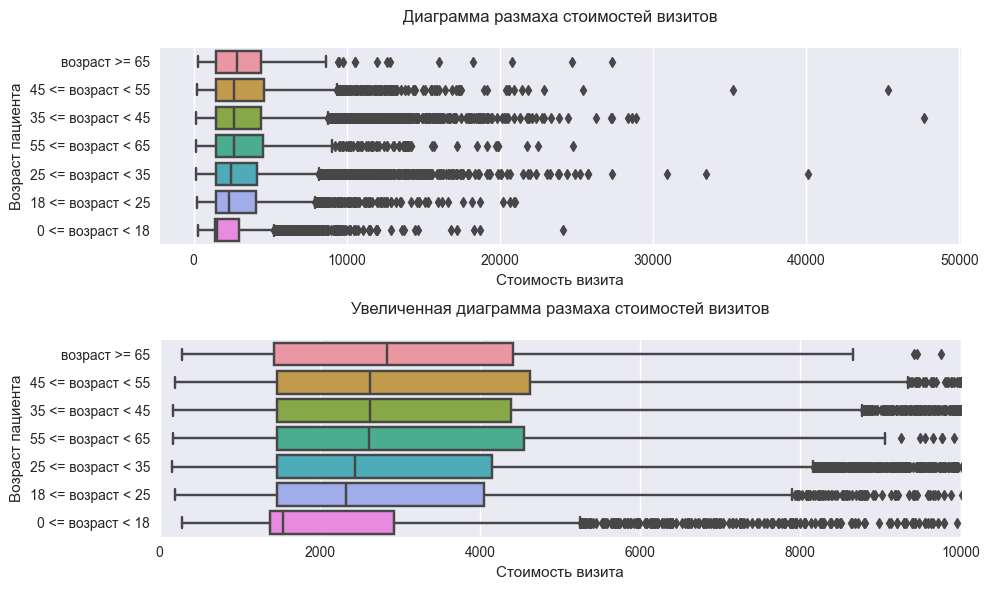

In [82]:
boxplot_cat(df=visits_insured, column='age_category_first', a=10000)

**Выбираем критерий t-test, так как:**
* выборки достаточно большие
* выборки независимые
* в выборках нет экстремально больших значений

**Гипотеза 5.7.2.1.**
* Нулевая гипотеза: средний чек за визит пациентов возраста "18 <= возраст < 25" равен среднему чеку за визит пациентов возраста "25 <= возраст < 35"
* Альтернативная гипотеза: средний чек за визит пациентов возраста "18 <= возраст < 25" не равен среднему чеку за визит пациентов возраста "25 <= возраст < 35"

In [84]:
# уровень значимости
alpha = 0.05
results = (
    st.ttest_ind(visits_insured.query('age_category_first == "18 <= возраст < 25"')['service_amount_sum'], 
                 visits_insured.query('age_category_first == "25 <= возраст < 35"')['service_amount_sum'],
                 equal_var=False)
) 
print(f'p-value: {results.pvalue:}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.46553892855026224
Не получилось отвергнуть нулевую гипотезу


**Гипотеза 5.7.2.2.**
* Нулевая гипотеза: средний чек за визит пациентов возраста "35 <= возраст < 45" равен среднему чеку за визит пациентов возраста "45 <= возраст < 55"
* Альтернативная гипотеза: средний чек за визит пациентов возраста "35 <= возраст < 45" не равен среднему чеку за визит пациентов возраста "45 <= возраст < 55"

In [85]:
# уровень значимости
alpha = 0.05
results = (
    st.ttest_ind(visits_insured.query('age_category_first == "35 <= возраст < 45"')['service_amount_sum'], 
                 visits_insured.query('age_category_first == "45 <= возраст < 55"')['service_amount_sum'],
                 equal_var=False)
) 
print(f'p-value: {results.pvalue:}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.17686742802510616
Не получилось отвергнуть нулевую гипотезу


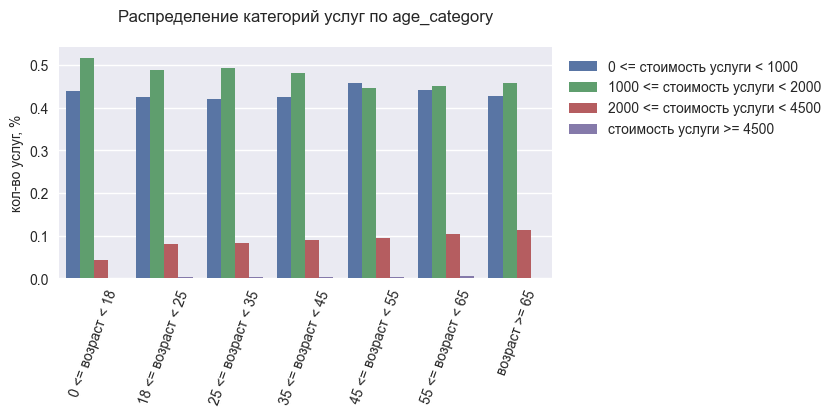

In [102]:
# рассмотрим, услуги каких ценовых категорий в основном берут пациенты разных возрастов
amount_dif_cat(data, 'age_category', 'amount_category')

**Промежуточный вывод:**
* по распределению ценовых категорий по возрастам можно отметить, что с возрастом количество услуг "2000 <= стоимость услуги < 4500"  увеличивается , а услуг "1000 <= стоимость услуги < 2000" наоборот уменьшается, что говорит о том, что с возрастом после приема, количество направлений на "диагностику и лечение" увеличивается

<a id='amount_age'><a/>

**Промежуточный вывод по влиянию возраста пацента на выручку (по 5.7.2.)**
1. самый "больной" возраст — от 25 до 35 лет, так как они принесли ~38% общей выручки, далее 35-45: ~31,5%, на третьем месте  45-55: ~11,4%, пациенты остальных возрастов принесли меньше 10% по каждой категории. 

2. По большей части объем выручки связан с количеством пациентов по категориям, но зависимость не совсем прямая. 
  * Проверка гипотез 5.7.2.1 показала, что на имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу для пациентов категори **18 <= возраст < 25** и **25 <= возраст < 35**
  * Проверка гипотез 5.7.2.2 показала, что на имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу для пациентов категори **35 <= возраст < 45** и **45 <= возраст < 55**
  * Таким образом при проведении акций или специальных предложений можно учитывать, что пациентов возраста от 18 до 35 можно объединить в одну группу, также пациентов возраста от 35 до 55 также можно объединить в одну группу по средней стоимости визита
3. по распределению ценовых категорий по возрастам можно отметить, что с возрастом количество услуг "2000 <= стоимость услуги < 4500"  увеличивается , а услуг "1000 <= стоимость услуги < 2000" наоборот уменьшается, что говорит о том, что с возрастом после приема, количество направлений на "диагностику и лечение" увеличивается

#### 5.7.3. Категория услуги: 'service_category'

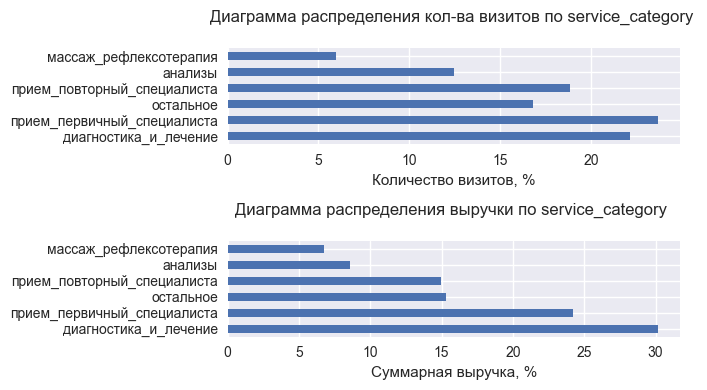

insured  service_amount  insured/ total, %  \
service_category                                                          
диагностика_и_лечение          11946        30067103             22.160   
прием_первичный_специалиста    12786        24086862             23.718   
остальное                       9069        15250169             16.823   
прием_повторный_специалиста    10171        14909509             18.867   
анализы                         6720         8528113             12.465   
массаж_рефлексотерапия          3217         6701011              5.967   

                             service_amount/ total, %  
service_category                                       
диагностика_и_лечение                          30.205  
прием_первичный_специалиста                    24.198  
остальное                                      15.320  
прием_повторный_специалиста                    14.978  
анализы                                         8.567  
массаж_рефлексотерапия                          6.732

In [87]:
# выведем общую выручку и количество пациентов с разделением по категориям услуг
plot_group(data, 'service_category')

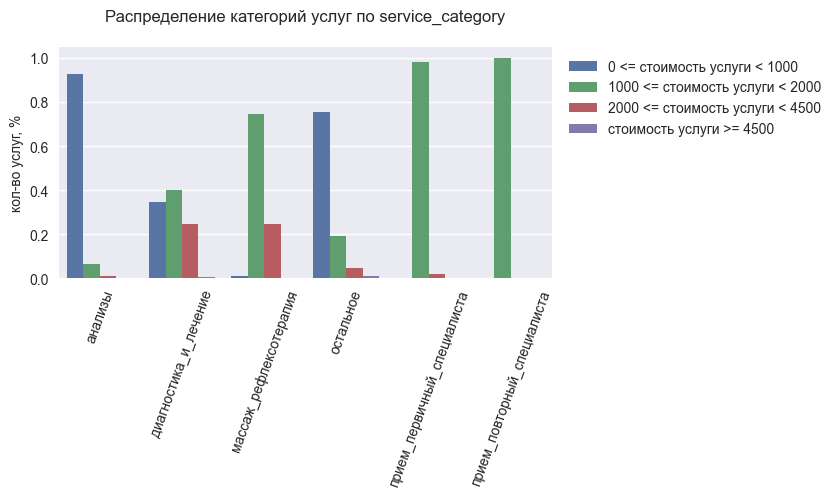

In [103]:
# рассмотрим, услуги каких ценовых диапазонов попадают в те или иные категории услугв
amount_dif_cat(data, 'service_category', 'amount_category')

<a id='amount_ser'><a/>

**Промежуточный вывод по распределению категорий услуг по ценовым диапазонам (по 5.7.3.)**
* больше всего выручки принесли категории "диагностика_и_лечение": ~30,2%, прием_первичный: ~24,2% и почти одинаковые значения у категорий прием_повторный и остальное: ~15%

    1. основной ценовой диапазон первичного_приема и повторного_приема — "1000 <= стоимость услуги < 2000" 
    2. категория диагностика_и_лечение на ~35% состоит из услуг ценового диапазона "0 <= стоимость услуги < 1000", на ~40% состоит из услуг ценового диапазона "1000 <= стоимость услуги < 2000" и на на ~25% состоит из услуг ценового диапазона "2000 <= стоимость услуги < 4500"
    3. категории анализы и остальное состоят преимущественно из услуг ценового диапазона "0 <= стоимость услуги < 1000" 
    4. категория "массаж_рефлексотерапия" при малом количестве сравнима по выручке с категорией "анализы" (которых в ~2 раз больше ) из-за ценовых категорий услуг("1000 <= стоимость услуги < 2000" и "2000 <= стоимость услуги < 4500")

* выручку в итоге приносят первичные приемы специалистов и назначаемые ими процедуры

#### 5.7.4. Ценовая категория услуги: 'amount_category'

<a id='amount'><a/>

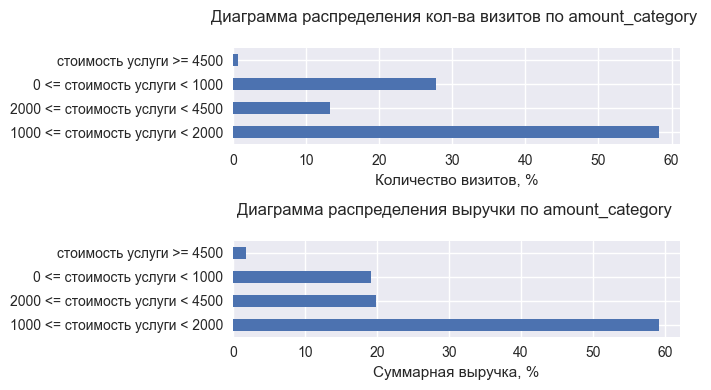

insured  service_amount  insured/ total, %  \
amount_category                                                               
1000 <= стоимость услуги < 2000    25808        58858399             58.240   
2000 <= стоимость услуги < 4500     5899        19797615             13.312   
0 <= стоимость услуги < 1000       12318        19075435             27.798   
стоимость услуги >= 4500             288         1811318              0.650   

                                 service_amount/ total, %  
amount_category                                            
1000 <= стоимость услуги < 2000                    59.129  
2000 <= стоимость услуги < 4500                    19.889  
0 <= стоимость услуги < 1000                       19.163  
стоимость услуги >= 4500                            1.820

In [89]:
# выведем общую выручку и количество пациентов с разделением по ценовому диапазону услуг
plot_group(data, 'amount_category')

**Промежуточный вывод: за весь рассматриваемый период**
* распределение выручки по ценовым категориям: 
  * "1000 <= стоимость услуги < 2000" — ~60%
  * "2000 <= стоимость услуги < 4500" и "0 <= стоимость услуги < 1000" — ~19-20%
  * "стоимость услуги >= 4500" — ~1,8%


<a id='summary'></a>
## 6. Общий вывод

**Цель проекта:**

Оценить вклад различных факторов в изменение средней стоимости лечения в медицинской клинике в разные годы.
Проанализировать изменение выручки медицинского центра в 2022 году относительно 2021 и выявить ключевые факторы, повлиявшие на это изменение.

**Общие данные:**
* Рассматриваемый период: 01.2021- 08.2022
* Общая выручка за весь период: 99 542 767,00 р.
  - Общая выручка за 2021 год (01-12 месяцы): 50 556 105,00 р.
  - Общая выручка за 2022 год (01-08 месяцы): 48 986 662,00 р.
* Общее число уникальных пациентов: 4487 человек
  - количество визитов в 2021 году (01-12 месяцы): 15 856
  - количество визитов в 2022 году (01-08 месяцы): 14 434

**Динамика выручки:**
* 2022 год показывает более динамичное изменение объема выручки и количества оказанных услуг
* каждый месяц 2022 года до 06 месяца включительно показывает рост и по количеству визитов, и по выручке относительно тех же месяцев в 2021 году [график динамики общей выручки](#total_amount)
* при сравнении одних и тех же месяцев 2021 и 2022 года, прирост выручки выше, чем прирост количества услуг на 7-12%. В июле же 2022 года выручка больше выручки 07.2021 на 60%, а количество услуг на 36,6%. Это говорит о том, что услуги в 2022 году дороже, чем те же услуги в 2021 году.
* 08.2022 наблюдается падение и количества визитов, и количества услуг и соответственно выручки до значений марта 2021 года


**Причины падения выручки**
* стоимость визита выросла из-за повышения стоимости услуг 10.2021 и 07.2022. Для оценки критичности падения выручки 08.2022 не хватает данных хотя бы за 09.2022, так как 11.2021 году также наблюдается падение выручки после повышения стоимости услуг 10.2021, но в декабре выручка начала подниматься
* 08.2022 исчезли некоторые популярные услуги (УЗИ) для пациентов женского пола, возможно вместе с ними ушло часть пациентов в другие клиники
* возможно после второго повышения стоимости на почти все услуги — часть пациентов ушла к конкурентам
* слишком резкий скачок 04.2021, скорее всего связан с сезонными акциями, поэтому дальнейшее снижение — это возможное возвращение к исходному плану продаж


**Исследование "визита". Влияете ли на выручку изменения количества визитов за день, количества услуг за визит и стоимости визита**
* в рассматриваемый период среднее число визитов в день росло, за исключением государственных праздников и выходных, в которые наблюдаются падения среднего количества визитов и периода 12.21-01.22, в который наблюдается снижение скорее всего из-за зимних отпусков [см.график](#visits_count_day)
* с увеличением числа визитов можно отметить одновременно увеличение разброса и стоимостей визитов с течением времени
* при этом наблюдается увеличение средней стоимости визита [см.график](#mean_cost_visit) при уменьшении разброса среднего количества услуг за визит [см.график](#mean_count_service)
* динамика обратившихсяв мсяц повторяет сглаженную динамику количесва визитов в день [см. график](#count_insured_month)

**Исследование "стоимости услуг". Влияет ли на выручку стоимость услуг**
* практически для всех услуг дважды наблюдается систематическое повышение стоимости: 10.2021 и 07.2022. В целом цены на популярные услуги из категории анализов повысились до 15-16%, на приемы врачей - на 9-10%, и на различные исследования - на 7-8%
* стоит отметить, что в августе **исчезли некоторые популярные услуги, которые стабильно оказывались в течение всего рассматриваемого периода**: 
  * ультразвуковое_исследование_гинекология_трансвагинально_с_дс_сосудов,
  * рентгенография_шейного_отдела_позвоночника_(2_снимка),
  * ультразвуковое_исследование_щитовидной_железы_с_дс_сосудов


* распределение услуг по категориям за каждый месяц с течением времени практически не меняется [см.график](#rate_service_cat)
* в зависимости от пола и возраста набор популярных услуг разный [см.графики по полу](#sex_id_service) и [см.графики по возрасту](#age_cat_service)

  * ценовая категория "стоимость услуги >= 4500": видно, что с 10.2021 многие услуги пропали вообще, или предоставлялись лишь изредка [см. график](#amount_cat_service)
  * прием_первичный_специалиста: до 10.2021 года были такие услуги как консультация врача перед вакцинацией, а также выезд врача на дом, после 10.2021 года этих услуг уже нет. Я думаю, что они связаны с ковидными мерами [см. график](#service_cat_service)


**Исследование "постоянных" и "разовых" пациентов. Влияет ли на выручку количество постоянных клиентов или количество "разовых" клиентов**
* всего клинику посетило 4487 уникальных пациента
* 25% застрахованных посетило клиниику только один раз. По медианному значению можно предположить, что "разовый" визит — это прием врача и какие-то анализы. Есть небольшое кол-во выбросов, которые показывают стоимость визитов, в которых комплекс услуг. "Разовые" пациенты принесли всего 3,5% от всей выручки: для 25% от всех уникальных пациентов - это незначительно, поэтому можно сделать вывод, что "разовые" пациенты не влияют на рост и падение выручки в течение рассматриваемого периода [см.график](#one_time_insured)
* 25% застрахованных посетило клиниику 2-3 раза. Оставшиеся 50% пациентов посетило клинику от 4 до 94 раз
* основную выручку принесли пациенты, которые приходили более 1 раза

**Исследование "медицинский кейс". Влияет ли на выручку изменение количества медицинских кейсов, их стоимости и длительности**
* характер распределения медицинских кейсов по количеству визитов — обратно пропорционален количеству визитов за кейс: больше всего кейсов с одним визитом (практически 50%) и наоборот — меньшего всего кейсов в с большим количеством визитов [см.график](#med_case_fig)
* в рассматриваемый период не наблюдается тендеции в увеличении количества визитов за кейс
* рассматривать выручку по кейсу нецелесообразно, так как она приходит в клинику в течении всего кейса за каждый визит отдельно
* также часть медицинских кейсов, стартовавших или имевших очередной визит во второй половине августа еще не окончена, так как мы не знаем, будет ли следующий визит в сентябре или нет

**Исследование "влияние пола, возраста, категории услуг на общую выручку"**
* **Пол пациента / sex_id**
  * пациенты женского пола принесли выручки больше пациентов мужского пола в ~1,5 раза. Это связано не только с тем, что пациентов женского пола больше пациентов мужского пола [см.график](#amount_sex_id), но и с тем, что средний чек пациентов женского пола выше, чем средний чек пациентов мужского пола
  * диаграмма размаха также подтверждает медианные значения: визит пациентов женского пола "дороже" (=2430) визита пациентов мужского пола (=2216)
* **Возраст пациента / age_category**
  * самый "больной" возраст — от 25 до 35 лет, так как они принесли ~38% общей выручки, далее 35-45: ~31,5%, на третьем месте  45-55: ~11,4%, пациенты остальных возрастов принесли меньше 10% по каждой категории. 
  * По большей части объем выручки связан с количеством пациентов по категориям, но зависимость не совсем прямая. 
    * Проверка гипотез 5.7.2.1 показала, что на имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу для пациентов категори **18 <= возраст < 25** и **25 <= возраст < 35**
    * Проверка гипотез 5.7.2.2 показала, что на имеющихся данных на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу для пациентов категори **35 <= возраст < 45** и **45 <= возраст < 55**
    * Таким образом при проведении акций или специальных предложений можно учитывать, что пациентов возраста от 18 до 35 можно объединить в одну группу, также пациентов возраста от 35 до 55 также можно объединить в одну группу по средней стоимости визита
  * по распределению ценовых категорий по возрастам можно отметить, что с возрастом количество услуг "2000 <= стоимость услуги < 4500"  увеличивается , а услуг "1000 <= стоимость услуги < 2000" наоборот уменьшается, что говорит о том, что с возрастом после приема, количество направлений на "диагностику и лечение" увеличивается
* **Категория услуги / service_category**
* больше всего выручки принесли категории "диагностика_и_лечение": ~30,2%, прием_первичный: ~24,2% и почти одинаковые значения у категорий прием_повторный и остальное: ~15%
  * основной ценовой диапазон первичного_приема и повторного_приема — "1000 <= стоимость услуги < 2000" 
  * категория диагностика_и_лечение на ~35% состоит из услуг ценового диапазона "0 <= стоимость услуги < 1000", на ~40% состоит из услуг ценового диапазона "1000 <= стоимость услуги < 2000" и на на ~25% состоит из услуг ценового диапазона "2000 <= стоимость услуги < 4500"
  * категории анализы и остальное состоят преимущественно из услуг ценового диапазона "0 <= стоимость услуги < 1000" 
  * категория "массаж_рефлексотерапия" при малом количестве сравнима по выручке с категорией "анализы" (которых в ~2 раз больше ) из-за ценовых категорий услуг("1000 <= стоимость услуги < 2000" и "2000 <= стоимость услуги < 4500")
* основную выручку в итоге приносят первичные приемы специалистов и назначаемые ими процедуры

**итого:** общая выручка зависит не только от количества пациентов, но и от пола и возраста пациента, так как разные возрасты  берут услуги из разных ценовых категорий услуг, категории выбираемых услуг также влияют на общую выручку
